# Supply Chain Data Analytics

Analyzing and Forcasting Supermarket Sales

Stan Brouwer (Vrije Universiteit)  
Liz Chan (Master TSCM)  
Maaike Lamberst (Supply Chain Data analysis)  
Niek Schroor (Group 10)  
December 11, 2024

## 1 Data selection

We analyze, forecast and interpret the [Superstore sales](https://public.tableau.com/app/sample-data/sample_-_superstore.xls) provided by [Tableau](https://public.tableau.com/app/learn/sample-data) using different statistical and machine learning methods.

The dataset provided contains information about products, sales and profits of a fictitious US company. The dataset contains about 10,000 rows with 1,850 unique product names and 17 product subcategories, covering four consecutive years on a daily basis.

We describe our work in the PDF version. However, we would like to recommend reading our quarto manuscript *here* as it contains the **relevant** R code in the Article Notebook.

## 2 Data Pre-processing

The superstore data set we selected is of high quality: At first glance (which needs to be verified during the visualization), the data appears to have been recorded regularly and without interruptions. There is no sign of a sudden structural change. Since the data are consumer products, it should contain both trends and seasonality. Nevertheless, we have included hypothetical steps to demonstrate our understanding of the data preprocessing procedure. In detail, we did:

In [ ]:
# Clear workspace
rm(list = ls())
# Function to load (and install if necessary) dependencies
install_and_load <- function(packages) {
  install.packages(setdiff(packages, rownames(installed.packages())), dependencies = TRUE)
  invisible(lapply(packages, require, character.only = TRUE))
}
install_and_load(c("tidyverse", "readxl", "ggplot2", "lubridate", "stats", "Amelia","forecast", "tseries", "plotly", "stringr", "knitr", "kableExtra"))

Loading required package: tidyverse

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
Loading required package: readxl

Loading required package: Amelia

Loading required package: Rcpp
## 
## Amelia II: Multiple Imputation
## (Version 1.8.3, built: 2024-11-07)
## Copyright (C) 2005-2024 James Honaker, Gary King and Matthew Blackwell
## Refer to http://gking.harvard.edu/amelia/ for more information
## 
Loading required package: forecast

Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 
Loading required package: tseries

Loading required package: plotly

Attaching package: 'plotly'

The following object is masked from 'package:ggplot2':

    last_plot

The following object is masked from 'package:stats':

    filter

The following object is masked from 'package:graphics':

    layout

Loading required package: knitr

Loading required package: kableExtra

Attaching package: 'kableExtra'

The following object is masked from 'package:dplyr':

    group_rows

-   Remove whitespaces from column names
-   Remove the <code>Row_ID</code> column as it can be inferred by it’s index
-   Remove all columns with a single unique value, as storing these would be [redundant](https://few.vu.nl/~molenaar/courses/StatR/chapters/B-06-raw_data.html)
-   Ensure machine-readable date formats in <code>yyyy-mm-dd</code> as these usually differ per locale.
-   Ensure proper decimal separators
-   Calculate the number of missing values (both NA and empty string ““) per column.

In [ ]:
# Load the data
suppressWarnings({data <- read_excel("data/sample_-_superstore.xls")}) # The Postal code column is stored as 'text' but coerced to numeric, causing warnings which we suppress

# Improve column names
colnames(data) <- str_replace_all(colnames(data), " ", "_")
colnames(data) <- str_replace_all(colnames(data), "-", "_")

# Remove the 'Row_ID' column as it can be inferred by it's index
data <- subset(data, select = -`Row_ID`)

# Remove all columns that have only one unique value, as storing these would be redundant
data <- data[, sapply(data, function(col) length(unique(col)) > 1)]

# Ensure a machine-readable date format as these are usually horrible in excel files
data$Order_Date <- as.Date(data$Order_Date, format = "%Y-%m-%d")
data$Ship_Date <- as.Date(data$Ship_Date, format = "%Y-%m-%d")

# The readxl package by default uses the correct decimal separator (as opposed to base R)

# Calculate the number of missing values per column.
# Origional dates and R date objects are in unix time, which return NA when compared to text (empty string). These dates are stored as 'double' datatype, Thus we check character columns for empty strings, and all columns for NA values. 
missing_values <- sapply(data, function(col) {
  if (inherits(col, "Date")) {
    sum(is.na(col))
  } else if (is.character(col)) {
    sum(is.na(col) | col == "")
  } else {
    sum(is.na(col))
  }
})

# sum(missing_values) returns 0!

# Optionally, print the missing values as a nice table
missing_values_table <- data.frame(
  Column = names(missing_values),
  Missing_or_Empty = missing_values
)
# Note that there are no missing values, thus we do not print them
# kable(missing_values_table, caption = "Missing or Empty Values in Columns", format = "pipe")


rm(missing_values, missing_values_table)

After these steps (and transposing the table for better document formatting), the data looks as follows:

In [ ]:
kable(t(head(data, 3)), caption = "First 3 Rows of the Data (Transposed)", format = "markdown")

We did not find any missing values, confirming the quality of the data set. There is some more processing to do, for instance the removal of outliers. However, by doing so we impose our own assumptions on the data. Let’s start by evaluating the descriptive statistics of our data and check if further processing is required.

In [ ]:
descriptive_statistics <- function(column) {
  if (is.numeric(column)) {
    stats <- list(
      Min = min(column, na.rm = TRUE), # Note that handling NA values increases robustness (and I copied the funciton from some of my earlier work)
      Max = max(column, na.rm = TRUE),
      Mean = mean(column, na.rm = TRUE),
      Median = median(column, na.rm = TRUE),
      StdDev = sd(column, na.rm = TRUE)
    )
  } else if (inherits(column, "Date")) {
    stats <- list(
      Earliest = format(min(column, na.rm = TRUE), "%Y-%m-%d"),
      Latest = format(max(column, na.rm = TRUE), "%Y-%m-%d")
    )
  } else if (is.character(column)) {
    stats <- list(
      Unique = length(unique(column)),
      Mode = names(sort(table(column), decreasing = TRUE)[1])
    )
  } else {
    stats <- NULL
  }
  return(stats)
}

# Call function on dataframe
descriptive_stats <- lapply(data, descriptive_statistics)

# Separate to tables dependent on data type
numeric_stats <- as.data.frame(do.call(rbind, lapply(names(data), function(col_name) {
  if (is.numeric(data[[col_name]])) {
    c(Column = col_name, descriptive_stats[[col_name]])
  }
})), stringsAsFactors = FALSE)
date_stats <- as.data.frame(do.call(rbind, lapply(names(data), function(col_name) {
  if (inherits(data[[col_name]], "Date")) {
    c(Column = col_name, descriptive_stats[[col_name]])
  }
})), stringsAsFactors = FALSE)
character_stats <- as.data.frame(do.call(rbind, lapply(names(data), function(col_name) {
  if (is.character(data[[col_name]])) {
    c(Column = col_name, descriptive_stats[[col_name]])
  }
})), stringsAsFactors = FALSE)

In [ ]:
kable(
  numeric_stats,
  caption = "Descriptive Statistics for Numeric Columns",
  format = "pipe")

We inspect the orders with the lowest and highest Sales amount (in USD). The most expensive orders were professional printers, cameras and teleconferencing units with high unit prices. The orders with the lowest sales amount were often binders and had a high Discount rate.

Interestingly there are orders with a negative profit. They typically have high Discount rates and often concern the same item, such as the “Cubify CubeX 3D Printer Triple Head Print”. The orders with a negative Profit were often part of a larger order (for instance CA-2016-108196), and placed by customers with multiple orders. We suspect these negative Profit’s to be caused by items of lower quality that receive discounts, general discount codes, or volume discounts. However, due to the high discounts especially on orders with negative profit, we assume these to be valid orders.

\*\* Some negative profit products \*\*

In figure x we plotted the quantities of the most sold products. Unfortunately, the sold quantities of individual products were too low to determine any meaningful trends.

In [ ]:
# Optionally: print top 10 sale quantity barplot
# # Sum of Quantity for top products
# top_products <- data %>%
#   group_by(Product_Name) %>%
#   summarize(total_quantity = sum(Quantity, na.rm = TRUE)) %>%
#   arrange(desc(total_quantity)) %>%
#   slice_head(n = 10) %>% 
#   mutate(ProdName8 = substr(Product_Name, 1, 8)) # Truncate product names to the first 8 characters. Long names mess up formatting
# 
# # Plot
# ggplot(top_products, aes(x = reorder(ProdName8, -total_quantity), y = total_quantity)) +
#   geom_bar(stat = "identity", fill = "steelblue") +
#   labs(title = "Top 20 Most Sold Products",
#        x = "Product ID",
#        y = "Total Quantity") +
#   theme_minimal() +
#   coord_flip()

# Aggregate quantity by Product Name and Order Date to create a time series
time_series_data <- data %>%
  group_by(Product_Name, Order_Date) %>%
  summarize(total_quantity = sum(Quantity, na.rm = TRUE)) %>%
  ungroup()

`summarise()` has grouped output by 'Product_Name'. You can override using the
`.groups` argument.

In [ ]:
# Plot interactive figure in html, plot ggplot2 in pdf:

# Creating the ggplotly object
p_ly <- ggplotly(ggplot(filtered_time_series_data, aes(x = Order_Date, y = total_quantity, color = ProdName10)) +
  geom_line(size = 1) +
  labs(title = "Quantity Sold Over Time per Product",
       x = "Order Date",
       y = "Quantity Sold") +
  theme_minimal() +
  theme(legend.position = "bottom") +
  scale_color_discrete(name = "Product Name"))

ℹ Please use `linewidth` instead.

Our proposed workaround is to aggregate <code>Product_Name</code> by <code>Sub_Category</code>, and treat it as a single product for the rest of the assignment, which we plotted in figure X.

In [ ]:
# Bar plots

# # Count frequency of top 20 products
# top_products <- data %>%
#   count(Product_Name, sort = TRUE) %>%
#   top_n(20, n) %>%
#   mutate(ProdName8 = substr(Product_Name, 1, 8))
# 
# # Plot!
# ggplot(top_products, aes(x = reorder(`ProdName8`, -n), y = n)) +
#   geom_bar(stat = "identity", fill = "steelblue") +
#   labs(title = "Top 20 Most Sold Products",
#        x = "Product Name",
#        y = "Quantity sold") +
#   theme_minimal() +
#   coord_flip()
# 
# Count frequency of top 20 products
top_categories <- data %>%
  count(Sub_Category, sort = TRUE)
# 
# # Plot!
# ggplot(top_categories, aes(x = reorder(Sub_Category, -n), y = n)) +
#   geom_bar(stat = "identity", fill = "steelblue") +
#   labs(title = "Sub_Categories sorted",
#        x = "Product Name",
#        y = "Quantity sold") +
#   theme_minimal() +
#   coord_flip()

# Find top 10 most sold product names
top_10_categories <- top_categories$Sub_Category[0:10]

# Filter the data for  top 10 products
top_10_data <- data %>% filter(Sub_Category %in% top_10_categories)

# calculate sales per month
top_10_data <- top_10_data %>%
  mutate(Month = floor_date(Order_Date, unit = "month"))

# Aggregate data by month for each sub-category
top_10_data_aggregated <- top_10_data %>%
  group_by(Month, Sub_Category) %>%
  summarise(Sales_Count = n(), .groups = 'drop')

# Some special interactive plot formatting (see previous plot)
p_ly <- ggplotly(ggplot(top_10_data_aggregated, aes(x = Month, y = Sales_Count, color = Sub_Category, group = Sub_Category)) +
    geom_line(size = 1) +
    geom_point(size = 2) +
    labs(title = "Monthly Sales for the Top 3 Most Sold Products",
         x = "Month",
         y = "Sales Count",
         color = "Product Name") +
    theme_minimal())

# Modify the visibility of traces
for (i in seq_along(p_ly$x$data)) {
  if (i == 1) {
    p_ly$x$data[[i]]$visible <- TRUE  # Make the first trace visible
  } else {
    p_ly$x$data[[i]]$visible <- "legendonly"  # Hide the rest
  }
}

# Plot
p_ly

This aggregated Quantity starts to show trends and seasonality, and is much more useful to base predictions on! We will use these aggregated sub-categories for the rest of the assignment.

To properly finish our data preprocessing we ran some statistics on Quantity aggregated by Sub_Category. Table x contains some descriptive statistics.

In [ ]:
library(dplyr)
library(kableExtra)

# Summarize the data
outlier_summary <- data %>%
  group_by(Sub_Category) %>%
  summarize(
    Min = round(min(Quantity), 2),
    Mean = round(mean(Quantity), 2),
    Max = round(max(Quantity), 2),
    Sd = round(sd(Quantity), 2),
    CI_lower = round(Mean - 1.96 * (Sd / sqrt(n())), 2),
    CI_upper = round(Mean + 1.96 * (Sd / sqrt(n())), 2),
    .groups = "drop"
  )

# Output tables
kable(
  outlier_summary,
  caption = "Statistics for Sub_Category quantity",
  format = "pipe")

The statistics for <code>Quantity</code> aggregated by <code>Sub_Category</code> looks valid. We can visualize it as histogram and check for anomalies. Figure y contains histograms of <code>Quantity</code> per <code>Sub_Category</code>.

In [ ]:
sub_categories <- unique(data$Sub_Category)

p <- plot_ly()
for (i in seq_along(sub_categories)) {
  sub <- sub_categories[i]
  subset_data <- data %>% filter(Sub_Category == sub)
  p <- add_trace(
    p,
    x = subset_data$Quantity,
    type = "histogram",
    name = sub,
    visible = ifelse(i == 1, TRUE, FALSE)
  )
}

# We add a drop down menu for Sub_Category as toggling visibility in default ggplot2 adds the histograms up. Instead we want to be able to show each histogram seperately. 
dropdown_buttons <- lapply(seq_along(sub_categories), function(i) {
  list(
    method = "update",
    args = list(
      list(visible = lapply(seq_along(sub_categories), function(j) j == i)),
      list(xaxis = list(title = "Quantity", autorange = TRUE), 
           yaxis = list(title = "Frequency", autorange = TRUE))
    ),
    label = sub_categories[i]
  )
})

# Style drop down layout
p <- p %>%
  layout(
    title = "Distribution of Quantity Sold per Order by Sub-Category",
    xaxis = list(title = "Quantity"),
    yaxis = list(title = "Frequency"),
    showlegend = FALSE,  # Drop down instead of legend
    updatemenus = list(
      list(
        type = "dropdown",
        buttons = dropdown_buttons,
        direction = "down",
        x = 0.99,
        y = 0.99,
        showactive = TRUE,
        xanchor = "left",
        yanchor = "top"
      )
    )
  )
p

The histograms show that the quantities a right-skewed distributed. This is to be expected since most orders contain only a small number of items. We will not remove the outliers with large quantities since they appear valid..

## 3 Data Visualization

## 4 Forecasting Method Evaluation

### Forecasting top 3 product categories (4a)

Let’s forecast sold quantities for the three most sold sub-categories:

The steps taken for data preparation were:

-   Identifying Top Subcategories: The top three subcategories are selected from our dataset based on their sold quantities. The top three were: Binders, furnishing and paper.
-   The sold quantities are aggregated monthly to create a time series object which we can use in the forecasting.
-   A KPSS showed that the data is non stationary. First-order differencing is applied to transform the data from non-stationary to stationary. The KPSS results in a p-value \>0.05 showing the stationarity.

In [ ]:
# Find top 3 most sold product names
top_categories <- data %>%
  group_by(Sub_Category) %>%
  summarise(Total_Quantity = sum(Quantity)) %>%
  arrange(desc(Total_Quantity))
top_3_subcategories <- top_categories$Sub_Category[0:3]

# Filter the data for  top 3 products
top_3_data <- data %>% filter(Sub_Category %in% top_3_subcategories)

# calculate sales per month
top_3_data <- top_3_data %>%
  mutate(Month = floor_date(Order_Date, unit = "month"))

# Aggregate data by month for each product
top_3_data_aggregated <- top_3_data %>%
  group_by(Month, Sub_Category) %>%
  summarise(Sales_Count = n(), .groups = 'drop')

# Create a time series object for each product
ts_data <- top_3_data_aggregated %>%
  pivot_wider(names_from = Sub_Category, values_from = Sales_Count, values_fill = 0) %>%
  select(-Month) %>%
  as.matrix()

# Create a time series object
ts_data <- ts(ts_data, start = c(2014, 1), end = c(2017, 12), frequency = 12)

# Create a time series list for each subcategory
ts_list <- list()

for (subcategory in top_3_subcategories) {
  # Filter data for the subcategory
  subcategory_data <- top_3_data_aggregated %>% filter(Sub_Category == subcategory)

  # Create a time series object (assuming monthly data from January 2014 to December 2017)
  ts_list[[subcategory]] <- ts(subcategory_data$Sales_Count,
                                start = c(2014, 1),
                                end = c(2017, 12),
                                frequency = 12)
}

#### 4 A
# Step 4: Apply forecasting methods to the top 3 sub-categories
forecast_results <- list()  # Store results

for (subcategory in names(ts_list)) {
  ts_current <- ts_list[[subcategory]]

  # Split the data into training and validation sets (70% training, 30% testing)
  train_size <- floor(0.7 * length(ts_current))
  train_ts <- window(ts_current, end = c(2014 + (train_size - 1) %/% 12, (train_size - 1) %% 12 + 1))
  test_ts <- window(ts_current, start = c(2014 + train_size %/% 12, train_size %% 12 + 1))

  # 1. ARIMA
  arima_model <- auto.arima(train_ts)
  arima_forecast <- forecast(arima_model, h = length(test_ts))
  arima_accuracy <- accuracy(arima_forecast, test_ts)

  # 2. Holt-Winters
  hw_model <- HoltWinters(train_ts)
  hw_forecast <- forecast(hw_model, h = length(test_ts))
  hw_accuracy <- accuracy(hw_forecast, test_ts)

  # 3. ETS
  ets_model <- ets(train_ts)
  ets_forecast <- forecast(ets_model, h = length(test_ts))
  ets_accuracy <- accuracy(ets_forecast, test_ts)

  # Store results
  forecast_results[[subcategory]] <- list(
    ARIMA = list(Model = arima_model, Forecast = arima_forecast, Accuracy = arima_accuracy),
    HoltWinters = list(Model = hw_model, Forecast = hw_forecast, Accuracy = hw_accuracy),
    ETS = list(Model = ets_model, Forecast = ets_forecast, Accuracy = ets_accuracy)
  )
}


# For formatting, we ommitted almost all output. You can uncomment the code and check your output if you like.

# # Step 5: Print results
#  for (subcategory in names(forecast_results)) {
#   cat("\n\nResults for Sub_Category:", subcategory, "\n")
# 
#   cat("\nARIMA Accuracy:\n")
#   print(forecast_results[[subcategory]]$ARIMA$Accuracy)
# 
#   cat("\nHolt-Winters Accuracy:\n")
#   print(forecast_results[[subcategory]]$HoltWinters$Accuracy)
# 
#   cat("\nETS Accuracy:\n")
#   print(forecast_results[[subcategory]]$ETS$Accuracy)
# }

Three models are applied to each subcategory to forecast it. The models we use are: ARIMA, Holt-Winters and ETS. We have chosen these models because of their level of suitability for discrete time series data with all different levels of trend and seasonality. To evaluate the methods and its effectiveness , the data is split into a training set (70%) and testing set (30%).

To assess the results, we use the following performance metrics: ME, RMSE, MAE and MAPE. They are calculated for the training and testing phases of the forecast.

As we can see on the forecasting results ARIMA performed well for binders. We can state this because of the lowest RMSE if you compare it to the other models.

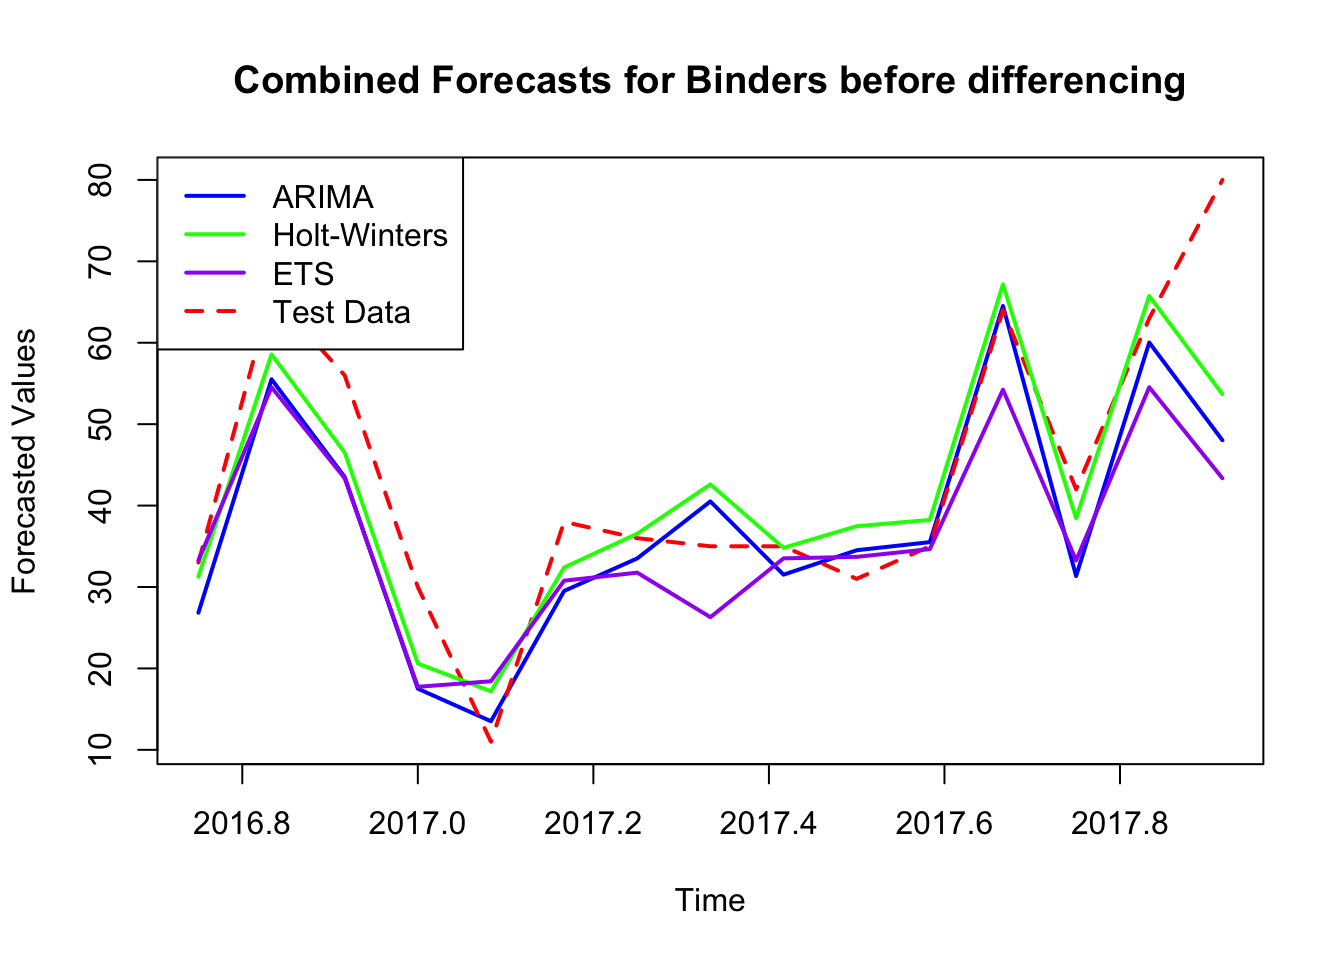

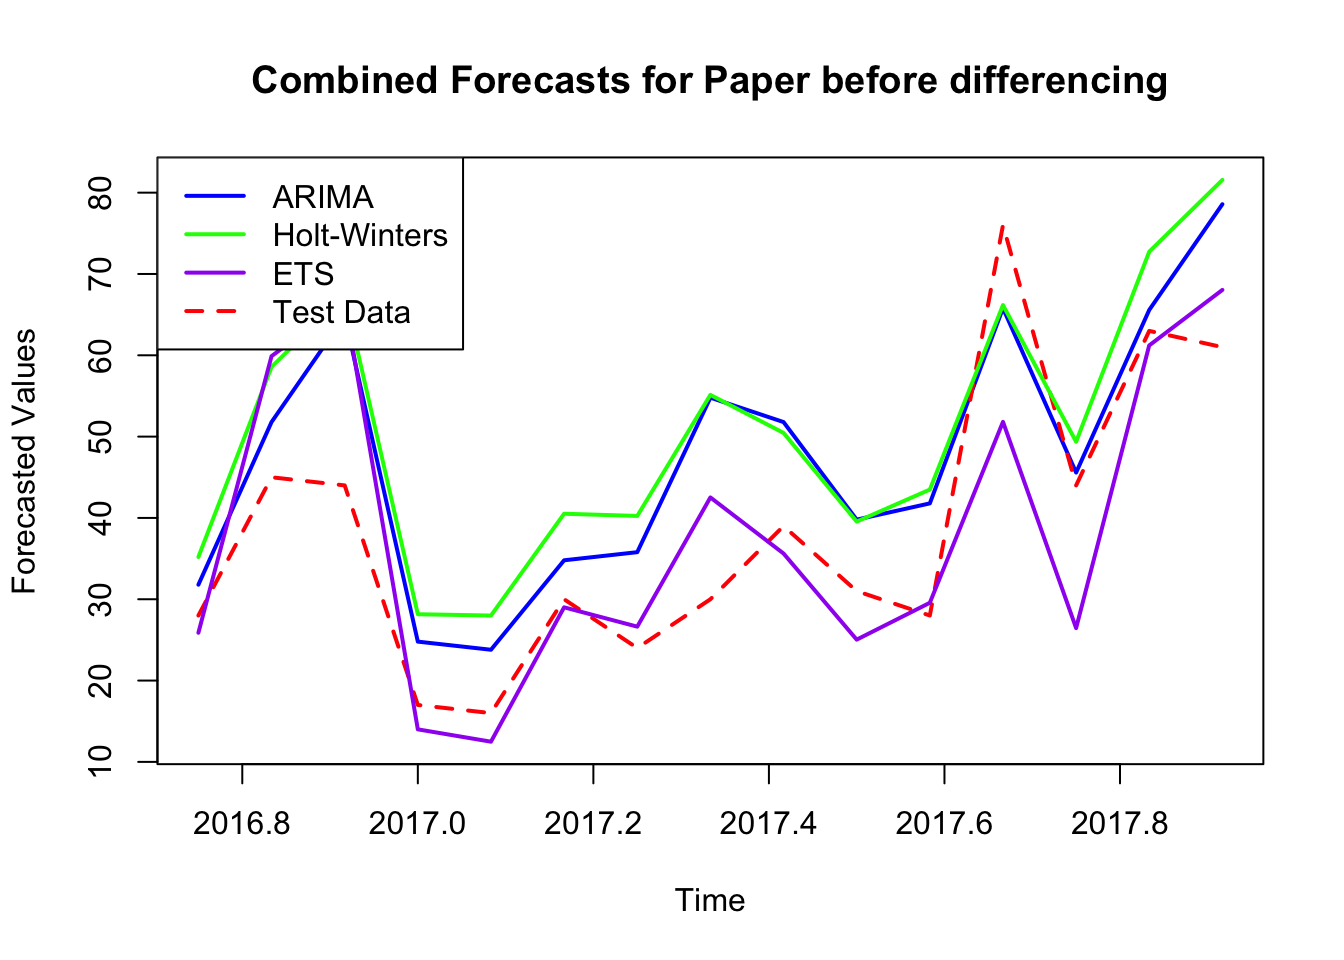

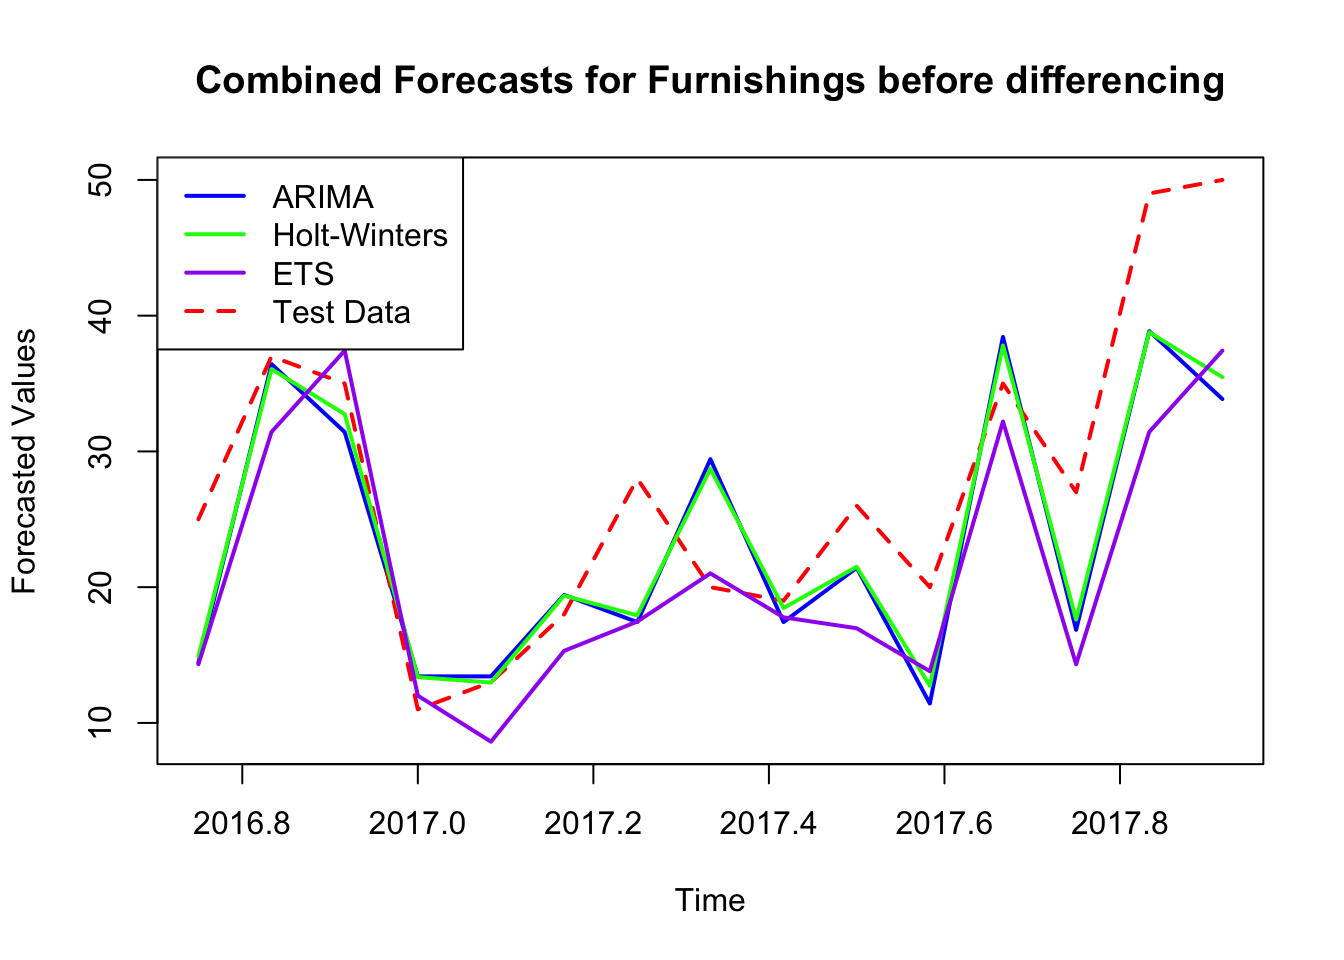

In [ ]:
# Lets plot the results
for (subcategory in names(forecast_results)) {
  ts_current <- ts_list[[subcategory]]
  train_size <- floor(0.7 * length(ts_current))
  test_ts <- window(ts_current, start = c(2014 + train_size %/% 12, train_size %% 12 + 1))
  arima_forecast <- forecast_results[[subcategory]]$ARIMA$Forecast
  hw_forecast <- forecast_results[[subcategory]]$HoltWinters$Forecast
  ets_forecast <- forecast_results[[subcategory]]$ETS$Forecast
  
  # Combined plot
  plot(arima_forecast$mean, col = "blue", lwd = 2, 
       ylim = range(c(arima_forecast$mean, hw_forecast$mean, ets_forecast$mean, test_ts)),
       main = paste("Combined Forecasts for", subcategory, "before differencing"),
       xlab = "Time", ylab = "Forecasted Values")
  lines(test_ts, col = "red", lty = 2, lwd = 2)
  lines(hw_forecast$mean, col = "green", lwd = 2)
  lines(ets_forecast$mean, col = "purple", lwd = 2)
  legend("topleft", legend = c("ARIMA", "Holt-Winters", "ETS", "Test Data"),
         col = c("blue", "green", "purple", "red"), lty = c(1, 1, 1, 2), lwd = 2)
}

In [ ]:
options(warn = -1)
# # Step 6: Visualization of Forecasts
# for (subcategory in names(forecast_results)) {
#   plot(forecast_results[[subcategory]]$ARIMA$Forecast, main = paste("ARIMA Forecast for", subcategory))
#   lines(test_ts, col = "red", lty = 2)
# 
#   plot(forecast_results[[subcategory]]$HoltWinters$Forecast, main = paste("Holt-Winters Forecast for", subcategory))
#   lines(test_ts, col = "red", lty = 2)
# 
#   plot(forecast_results[[subcategory]]$ETS$Forecast, main = paste("ETS Forecast for", subcategory))
#   lines(test_ts, col = "red", lty = 2)
# }

#more stationary tests
# Perform KPSS Test for the top 3 subcategories
# top_3_subcategories <- top_categories$Sub_Category[0:3]
# 
# for (subcategory in top_3_subcategories) {
#   if (subcategory %in% names(ts_list)) {
#     ts_current <- ts_list[[subcategory]]
#     cat("\nKPSS Test for Sub-Category:", subcategory, "\n")
#     print(kpss.test(ts_current))
#   } else {
#     cat("\nSub-Category not found in ts_list:", subcategory, "\n")
#   }
# }

#Because the all the 3 subcategory are non stationary because of a P value which is <=0.05 we need to use differencing
# Apply differencing to each of the top 3 subcategories
differenced_series <- list()

for (subcategory in top_3_subcategories) {
  if (subcategory %in% names(ts_list)) {
    ts_current <- ts_list[[subcategory]]  # Get the time series for the subcategory
    ts_diff <- diff(ts_current, differences = 1)  # Apply first-order differencing
    differenced_series[[subcategory]] <- ts_diff  # Store the differenced series

    # Recheck stationarity with KPSS test
    #cat("\nKPSS Test for Differenced Sub-Category:", subcategory, "\n")
    print(kpss.test(ts_diff))
  } else {
    #cat("\nSub-Category not found in ts_list:", subcategory, "\n")
  }
}


    KPSS Test for Level Stationarity

data:  ts_diff
KPSS Level = 0.10182, Truncation lag parameter = 3, p-value = 0.1


    KPSS Test for Level Stationarity

data:  ts_diff
KPSS Level = 0.061982, Truncation lag parameter = 3, p-value = 0.1


    KPSS Test for Level Stationarity

data:  ts_diff
KPSS Level = 0.098438, Truncation lag parameter = 3, p-value = 0.1

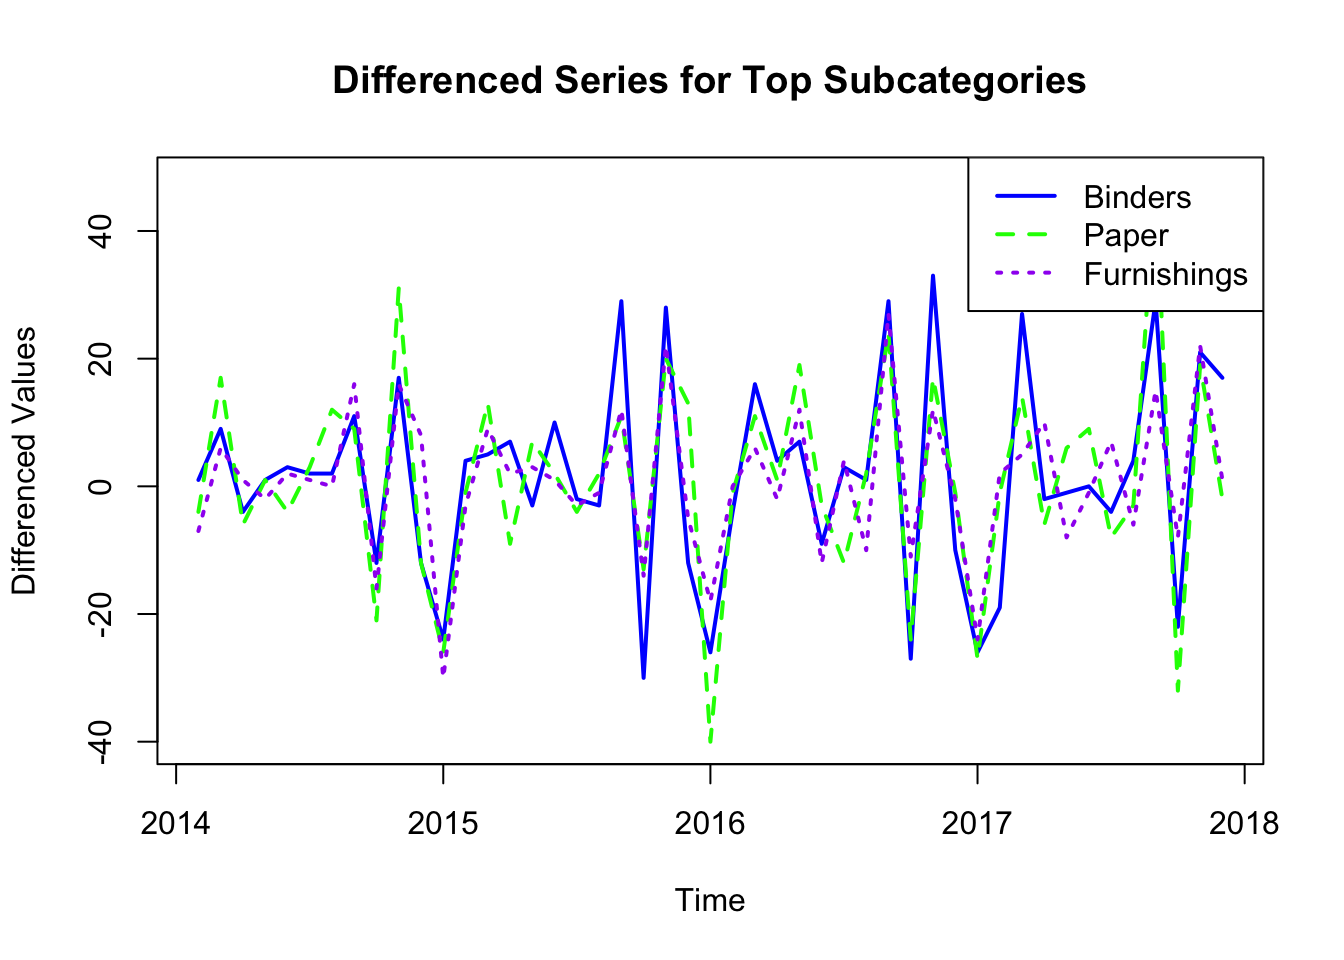

In [ ]:
# Time differenced plots
# # Now P value is larger then 0.05 so we have stationary data
# # Plot the differenced series for each subcategory
# for (subcategory in top_3_subcategories) {
#   if (subcategory %in% names(differenced_series)) {
#     ts_diff <- differenced_series[[subcategory]]
#     cat("\nPlotting Differenced Series for Sub-Category:", subcategory, "\n")
#     plot(ts_diff, main = paste("Differenced Series for Sub-Category:", subcategory),
#          ylab = "Differenced Values", xlab = "Time")
#   }
# }


# Combine differenced series plots for all top subcategories
combined_diff_plot <- function(differenced_series, top_3_subcategories) {
  plot(NULL, xlim = range(time(differenced_series[[top_3_subcategories[1]]])), 
       ylim = range(sapply(differenced_series[top_3_subcategories], range, na.rm = TRUE)),
       xlab = "Time", ylab = "Differenced Values",
       main = "Differenced Series for Top Subcategories")
  colors <- c("blue", "green", "purple")
  for (i in seq_along(top_3_subcategories)) {
    subcategory <- top_3_subcategories[i]
    if (subcategory %in% names(differenced_series)) {
      ts_diff <- differenced_series[[subcategory]]
      lines(ts_diff, col = colors[i], lwd = 2, lty = i)
    }
  }
  legend("topright", legend = top_3_subcategories, 
         col = colors, lty = 1:length(top_3_subcategories), lwd = 2)
}
combined_diff_plot(differenced_series, top_3_subcategories)

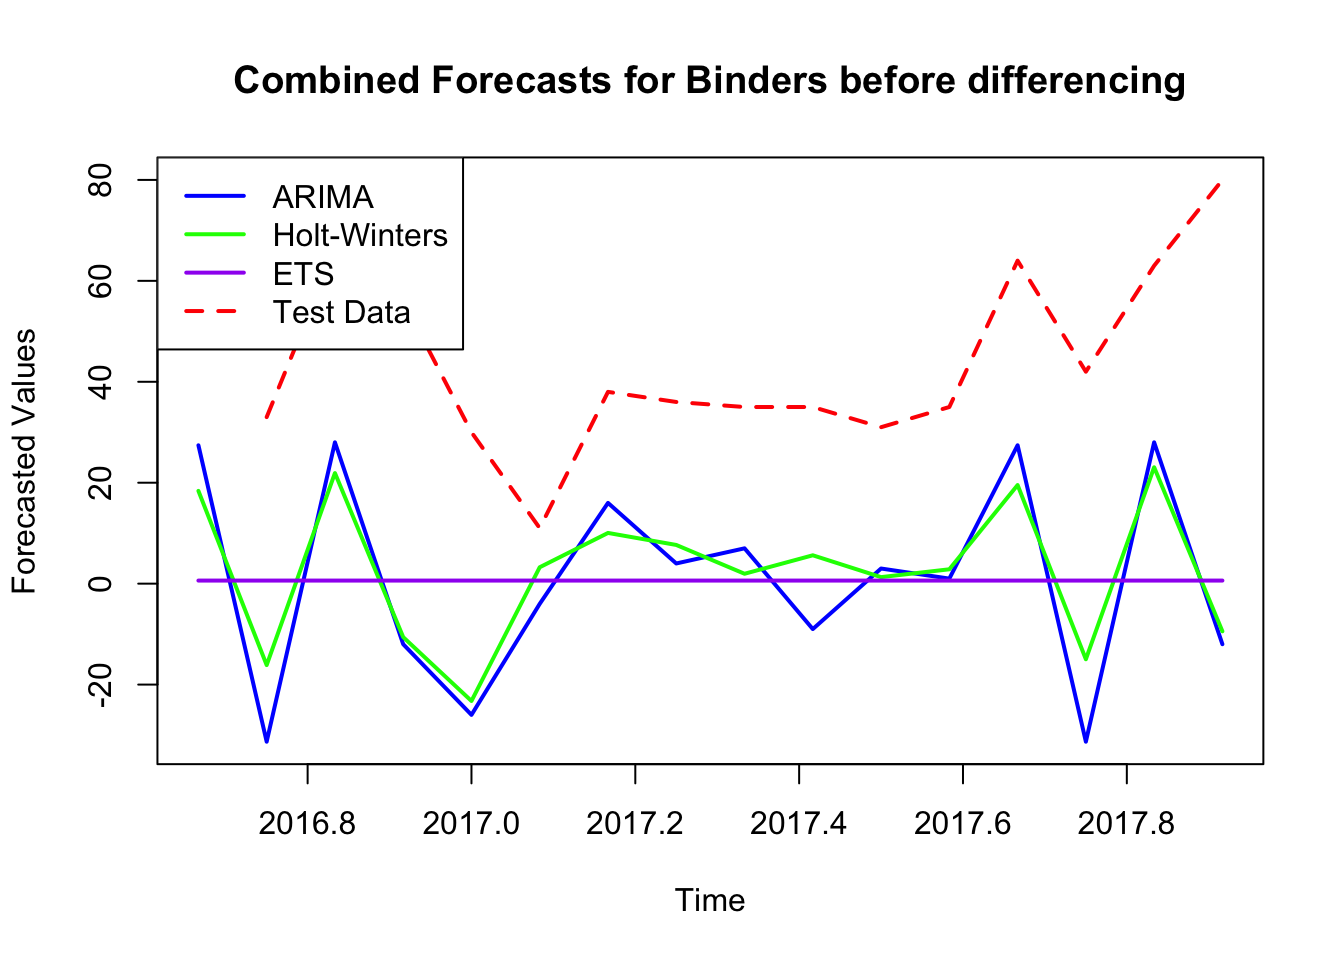

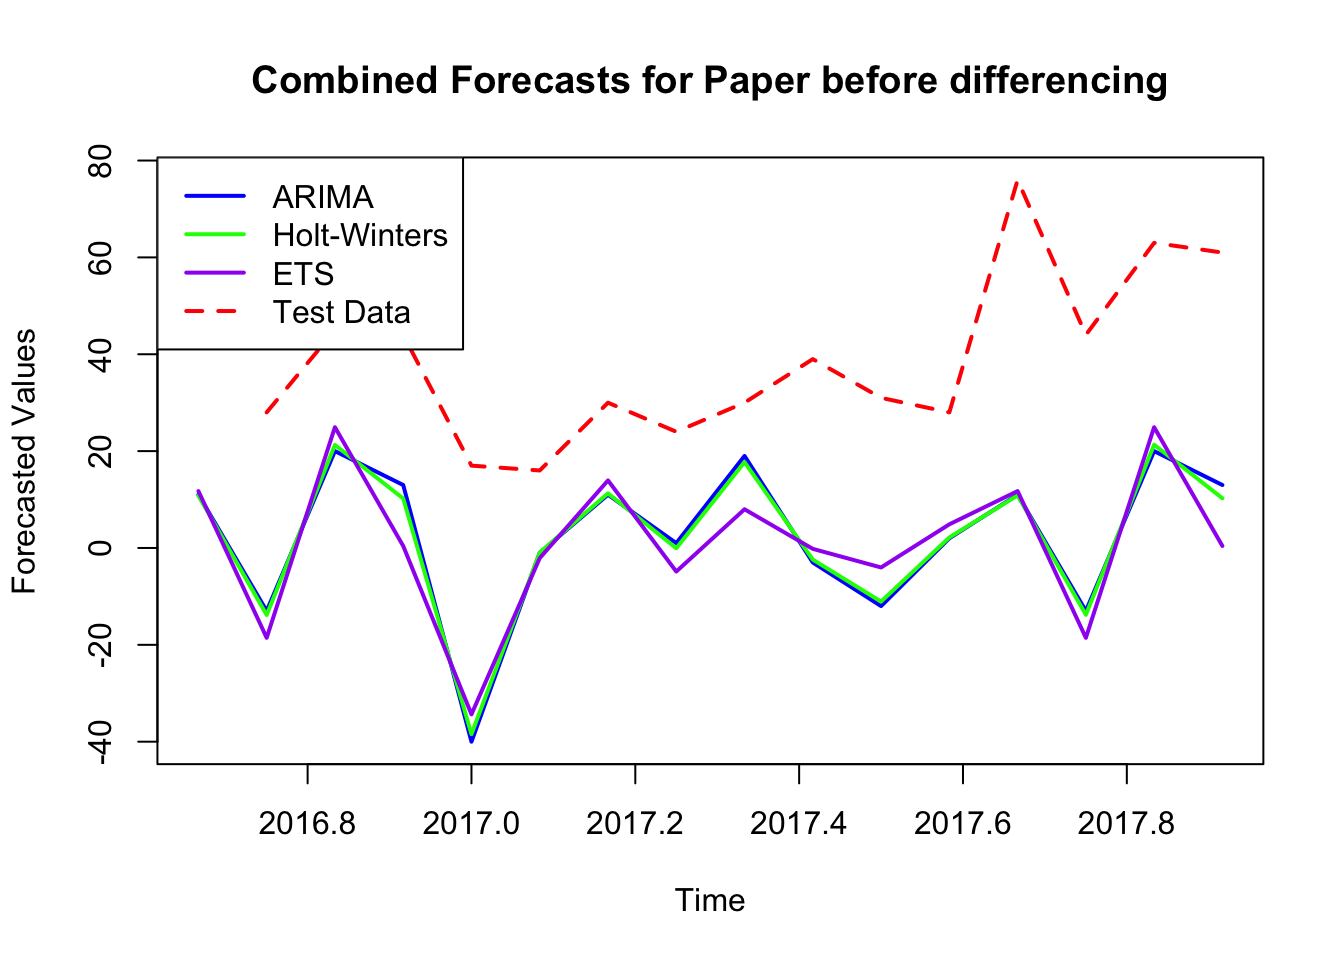

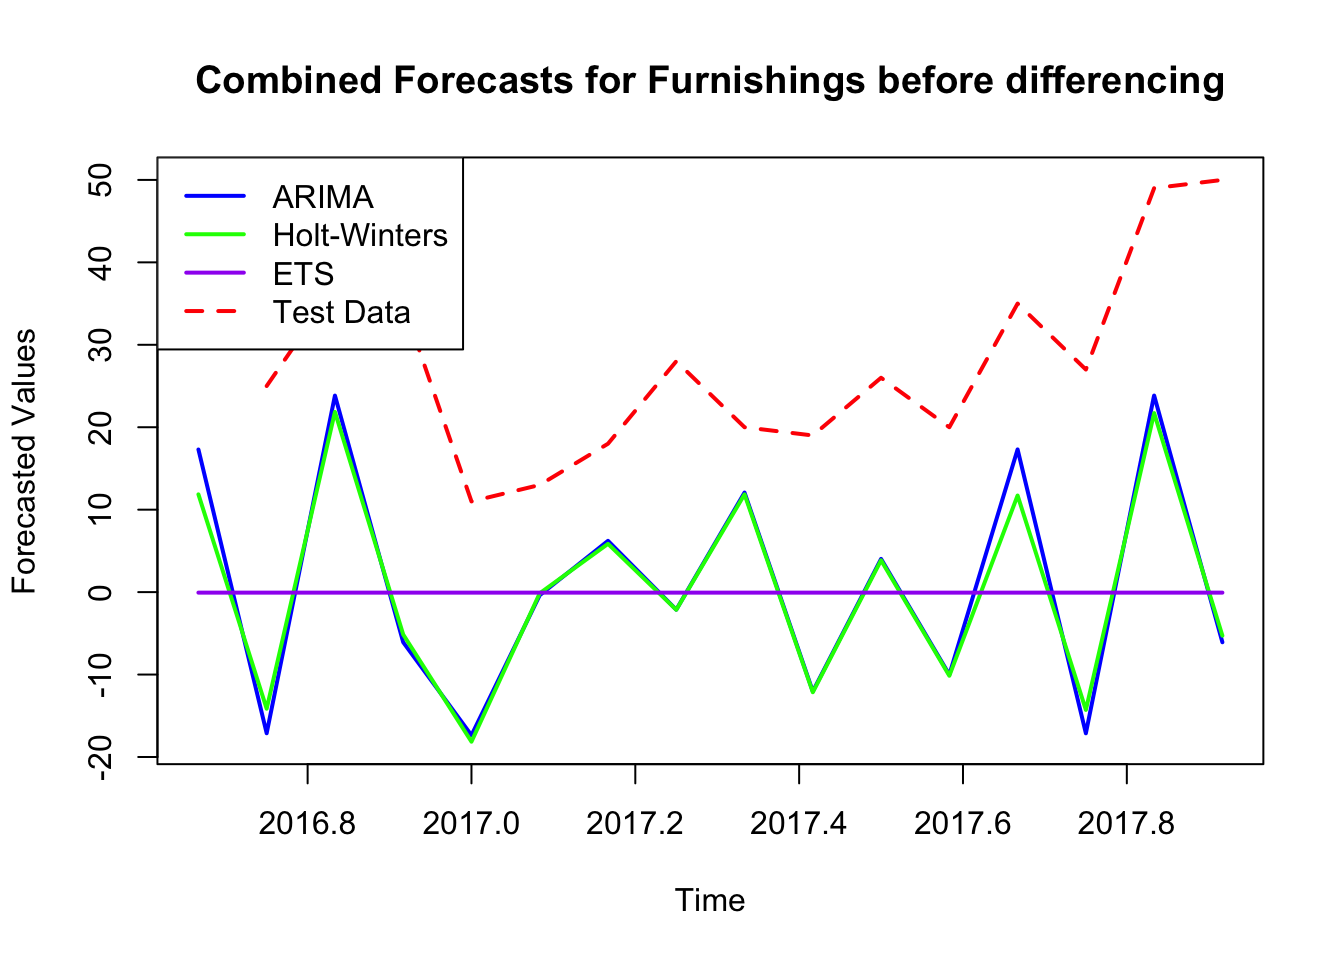

In [ ]:
#NEW FORECASTING FOR 4A with stationary data
# Step 4: Apply forecasting methods to the differenced top 3 sub-categories
forecast_results <- list()  # Store results

for (subcategory in names(differenced_series)) {
  ts_current <- differenced_series[[subcategory]]  # Use the differenced series

  # Split the data into training and validation sets (70% training, 30% testing)
  train_size <- floor(0.7 * length(ts_current))
  train_ts <- window(ts_current, end = c(2014 + (train_size - 1) %/% 12, (train_size - 1) %% 12 + 1))
  test_ts <- window(ts_current, start = c(2014 + train_size %/% 12, train_size %% 12 + 1))

  # 1. ARIMA
  arima_model <- auto.arima(train_ts)
  arima_forecast <- forecast(arima_model, h = length(test_ts))
  arima_accuracy <- accuracy(arima_forecast, test_ts)

  # 2. Holt-Winters
  hw_model <- HoltWinters(train_ts)
  hw_forecast <- forecast(hw_model, h = length(test_ts))
  hw_accuracy <- accuracy(hw_forecast, test_ts)

  # 3. ETS
  ets_model <- ets(train_ts)
  ets_forecast <- forecast(ets_model, h = length(test_ts))
  ets_accuracy <- accuracy(ets_forecast, test_ts)

  # Store results
  forecast_results[[subcategory]] <- list(
    ARIMA = list(Model = arima_model, Forecast = arima_forecast, Accuracy = arima_accuracy),
    HoltWinters = list(Model = hw_model, Forecast = hw_forecast, Accuracy = hw_accuracy),
    ETS = list(Model = ets_model, Forecast = ets_forecast, Accuracy = ets_accuracy)
  )
}

# # Step 5: Print results
# for (subcategory in names(forecast_results)) {
#   cat("\n\nResults for Sub_Category:", subcategory, "\n")
# 
#   cat("\nARIMA Accuracy:\n")
#   print(forecast_results[[subcategory]]$ARIMA$Accuracy)
# 
#   cat("\nHolt-Winters Accuracy:\n")
#   print(forecast_results[[subcategory]]$HoltWinters$Accuracy)
# 
#   cat("\nETS Accuracy:\n")
#   print(forecast_results[[subcategory]]$ETS$Accuracy)
# }

# # Step 6: Visualization of Forecasts
# for (subcategory in names(forecast_results)) {
#   plot(forecast_results[[subcategory]]$ARIMA$Forecast,
#        main = paste("ARIMA Forecast for", subcategory),
#        ylab = "Differenced Values", xlab = "Time")
#   lines(test_ts, col = "red", lty = 2)
# 
#   plot(forecast_results[[subcategory]]$HoltWinters$Forecast,
#        main = paste("Holt-Winters Forecast for", subcategory),
#        ylab = "Differenced Values", xlab = "Time")
#   lines(test_ts, col = "red", lty = 2)
# 
#   plot(forecast_results[[subcategory]]$ETS$Forecast,
#        main = paste("ETS Forecast for", subcategory),
#        ylab = "Differenced Values", xlab = "Time")
#   lines(test_ts, col = "red", lty = 2)
# }

# Lets plot the results
for (subcategory in names(forecast_results)) {
  ts_current <- ts_list[[subcategory]]
  train_size <- floor(0.7 * length(ts_current))
  test_ts <- window(ts_current, start = c(2014 + train_size %/% 12, train_size %% 12 + 1))
  arima_forecast <- forecast_results[[subcategory]]$ARIMA$Forecast
  hw_forecast <- forecast_results[[subcategory]]$HoltWinters$Forecast
  ets_forecast <- forecast_results[[subcategory]]$ETS$Forecast
  
  # Combined plot
  plot(arima_forecast$mean, col = "blue", lwd = 2, 
       ylim = range(c(arima_forecast$mean, hw_forecast$mean, ets_forecast$mean, test_ts)),
       main = paste("Combined Forecasts for", subcategory, "before differencing"),
       xlab = "Time", ylab = "Forecasted Values")
  lines(test_ts, col = "red", lty = 2, lwd = 2)
  lines(hw_forecast$mean, col = "green", lwd = 2)
  lines(ets_forecast$mean, col = "purple", lwd = 2)
  legend("topleft", legend = c("ARIMA", "Holt-Winters", "ETS", "Test Data"),
         col = c("blue", "green", "purple", "red"), lty = c(1, 1, 1, 2), lwd = 2)
}

In [ ]:
# final KPSS test

# Perform KPSS Test for the differenced series in the top 3 subcategories
for (subcategory in top_3_subcategories) {
  if (subcategory %in% names(differenced_series)) {
    ts_current <- differenced_series[[subcategory]]  # Get the differenced series
    cat("\nKPSS Test for Differenced Sub-Category:", subcategory, "\n")
    print(kpss.test(ts_current))
  } else {
    cat("\nSub-Category not found in differenced_series:", subcategory, "\n")
  }
}


KPSS Test for Differenced Sub-Category: Binders 

    KPSS Test for Level Stationarity

data:  ts_current
KPSS Level = 0.10182, Truncation lag parameter = 3, p-value = 0.1


KPSS Test for Differenced Sub-Category: Paper 

    KPSS Test for Level Stationarity

data:  ts_current
KPSS Level = 0.061982, Truncation lag parameter = 3, p-value = 0.1


KPSS Test for Differenced Sub-Category: Furnishings 

    KPSS Test for Level Stationarity

data:  ts_current
KPSS Level = 0.098438, Truncation lag parameter = 3, p-value = 0.1

As we can see on the forecasting results ARIMA performed well for binders. We can state this because of the lowest RMSE. - ARIMA Binders: - Forecasting results Binders:

For the subcategory furnishings we can see that the ETS forecasting method is the most stable across the training and testing phase. - ETS furnishings - Forecasting results Furnishings:

For the last subcategory and product paper the ETS model is again the most consistent, comparing the statistics for training and test set. The high variability in the test data leads to larger forecasting errors in all the 3 models.

-   ETS Furnishings:
-   Forecasting results:

Residual Diagnostics: - The checks show no real autocorrelation for ARIMA models. Which indicates a good fitting forecast.

### Conclusion (4a)

The most effective model is not the same in all the subcategories. Each model was validated based on its ability to capture seasonality and trend. ARIMA performed better for Binders, while ETS performed better for Furnishings and Paper.

### Clustering (4b)



Results for Cluster_1 

Sub-Category: Binders 

ARIMA Accuracy:
                    ME      RMSE      MAE        MPE     MAPE      MASE
Training set 0.7706014  4.643476 2.982256  0.6865304 12.91204 0.4854835
Test set     5.9407398 10.783528 7.616473 10.3681817 17.32927 1.2398909
                   ACF1 Theil's U
Training set 0.04429472        NA
Test set     0.04929320 0.3573866

Holt-Winters Accuracy:
                    ME     RMSE      MAE        MPE     MAPE      MASE
Training set 0.8668058 5.215491 3.789990 -0.4040374 15.36545 0.6169751
Test set     2.2473496 8.712049 6.243226  0.1597635 16.02219 1.0163391
                     ACF1 Theil's U
Training set -0.389045966        NA
Test set     -0.001830843 0.2777843

ETS Accuracy:
                   ME      RMSE      MAE       MPE     MAPE      MASE
Training set 0.743354  4.712561 3.656409  1.358692 15.41708 0.5952293
Test set     7.439784 12.216161 8.825094 10.667088 20.93561 1.4366433
                   ACF1 Theil's U
Training set

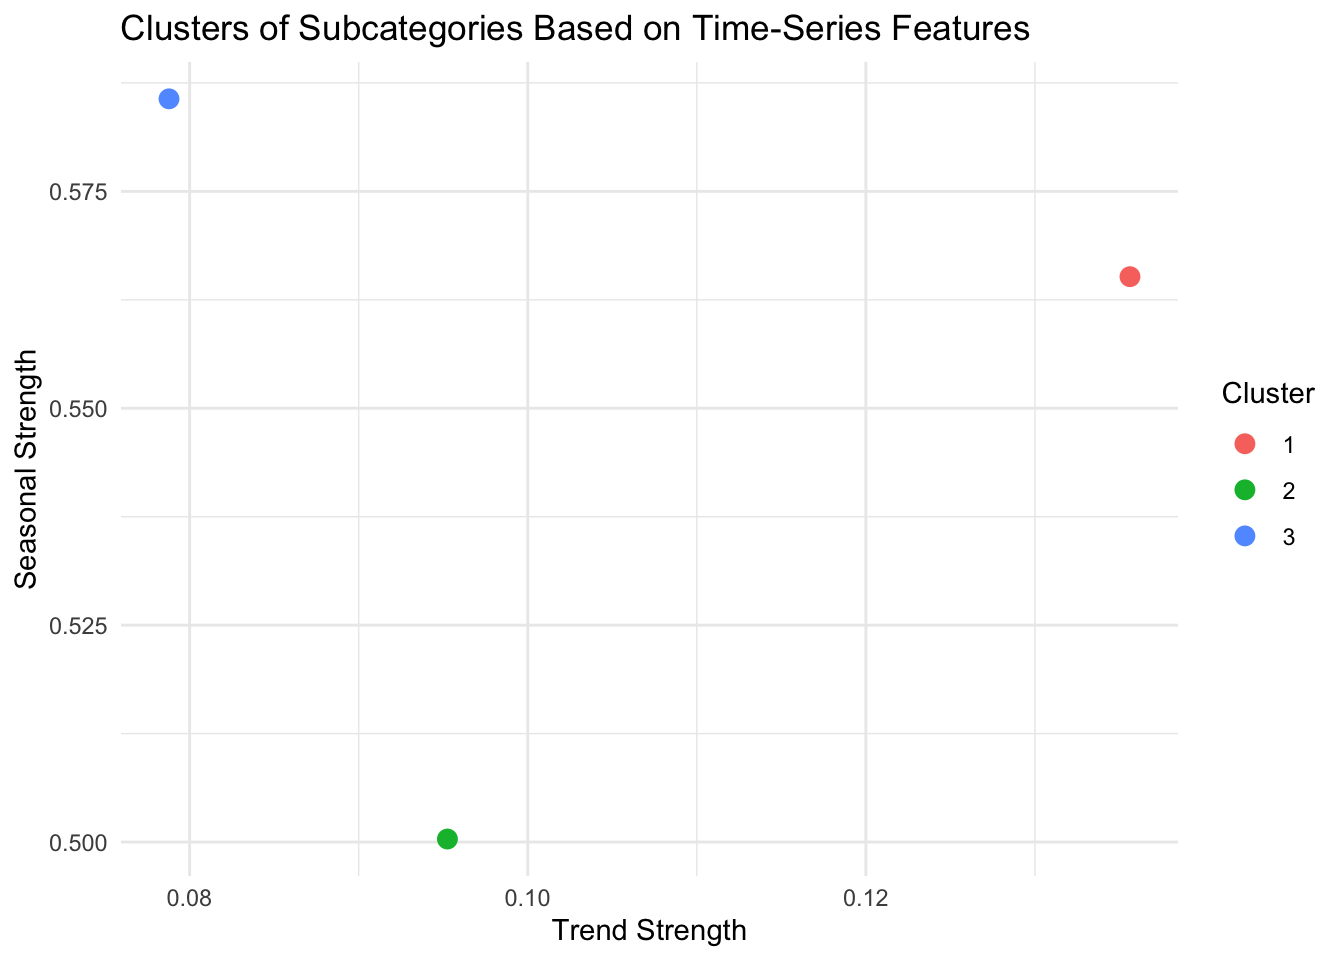


Residual Diagnostics for Sub-Category: Binders 

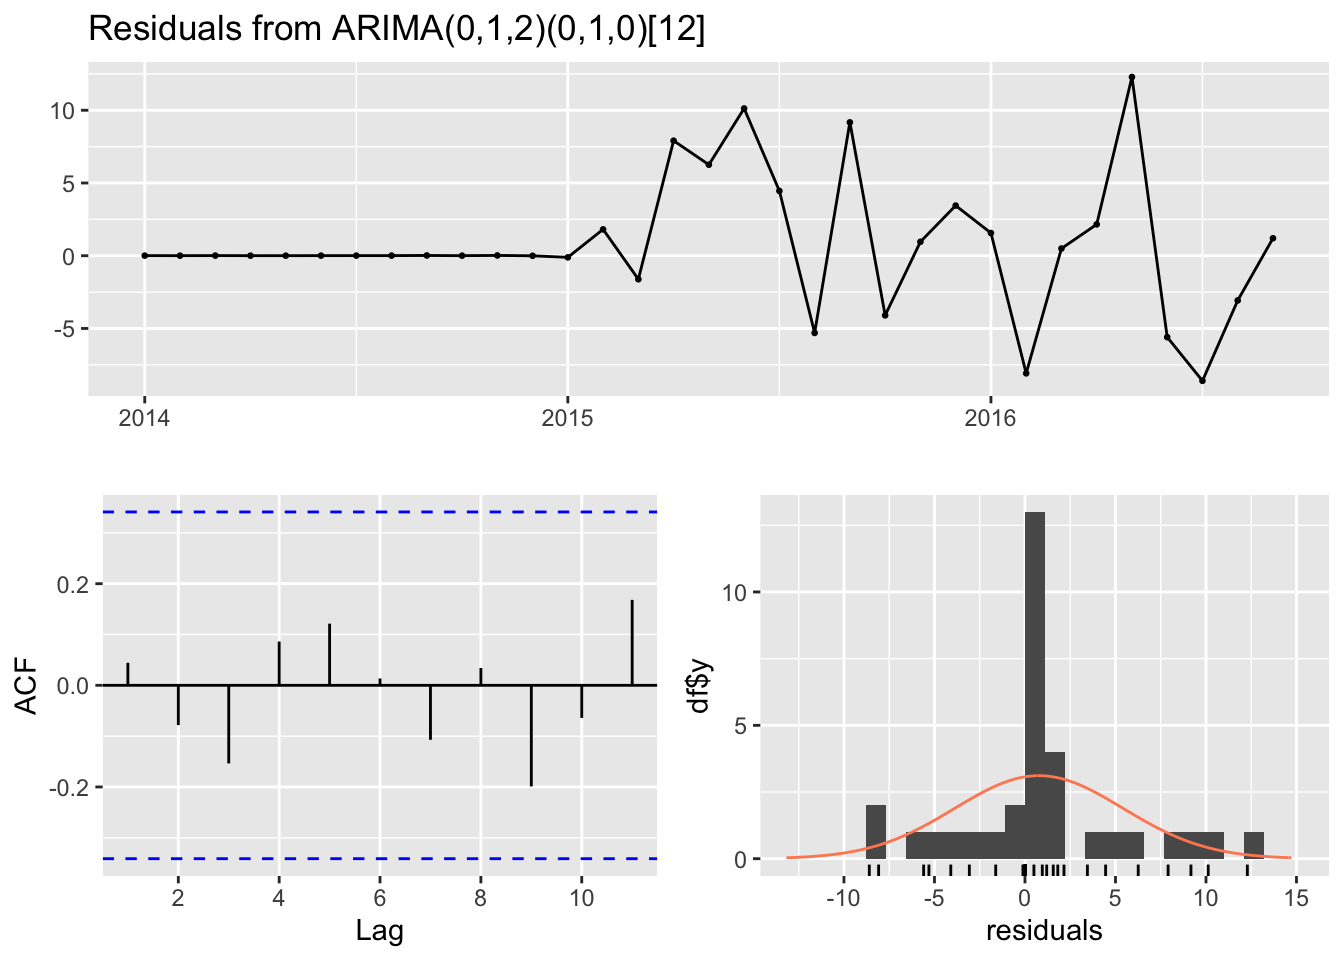


    Ljung-Box test

data:  Residuals from ARIMA(0,1,2)(0,1,0)[12]
Q* = 2.6295, df = 5, p-value = 0.7569

Model df: 2.   Total lags used: 7


Residual Diagnostics for Sub-Category: Paper 

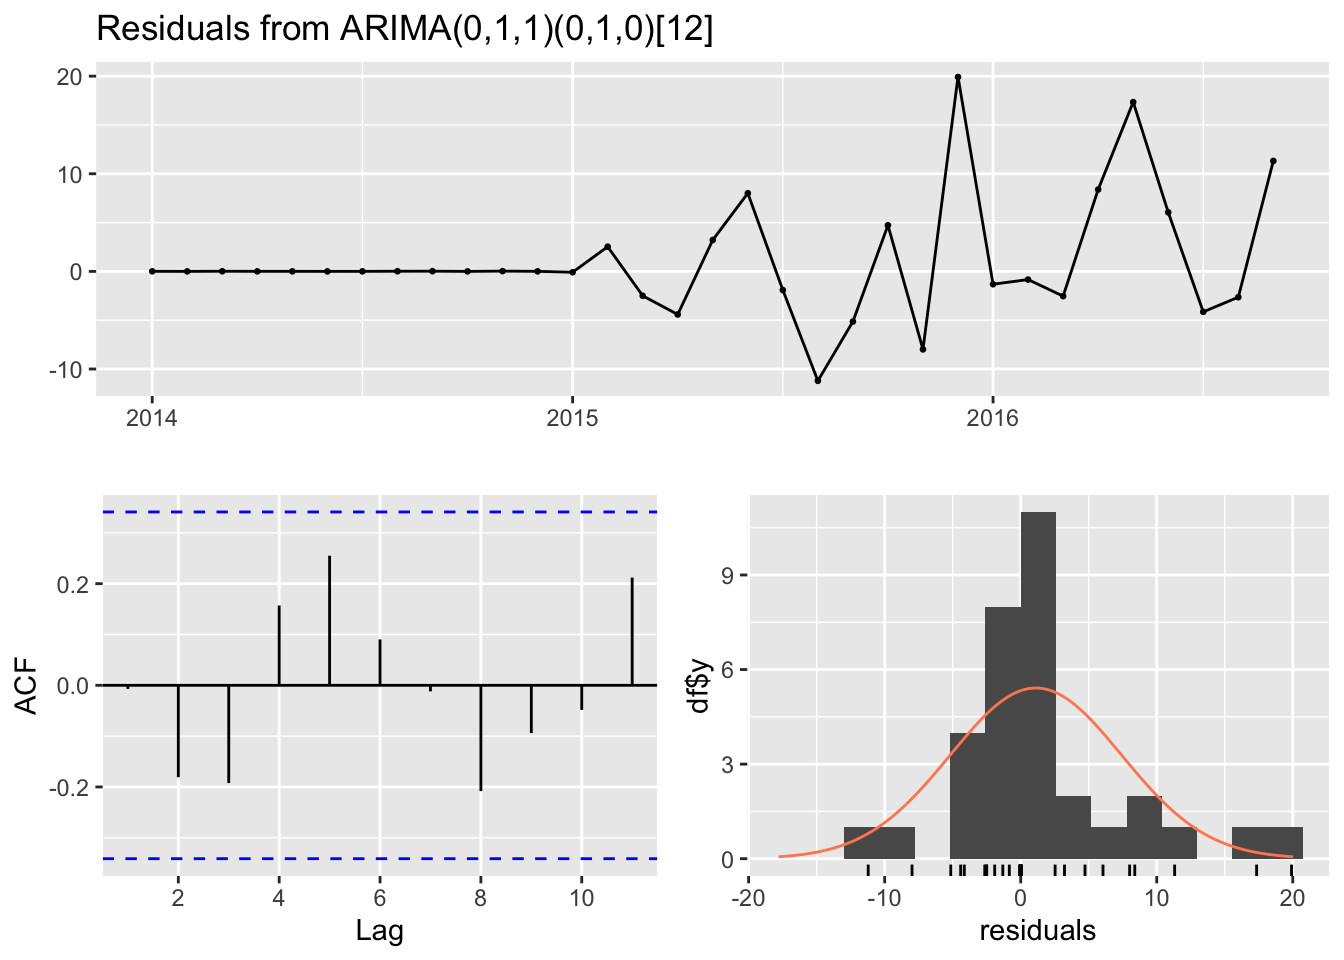


    Ljung-Box test

data:  Residuals from ARIMA(0,1,1)(0,1,0)[12]
Q* = 6.6676, df = 6, p-value = 0.3527

Model df: 1.   Total lags used: 7


Residual Diagnostics for Sub-Category: Furnishings 

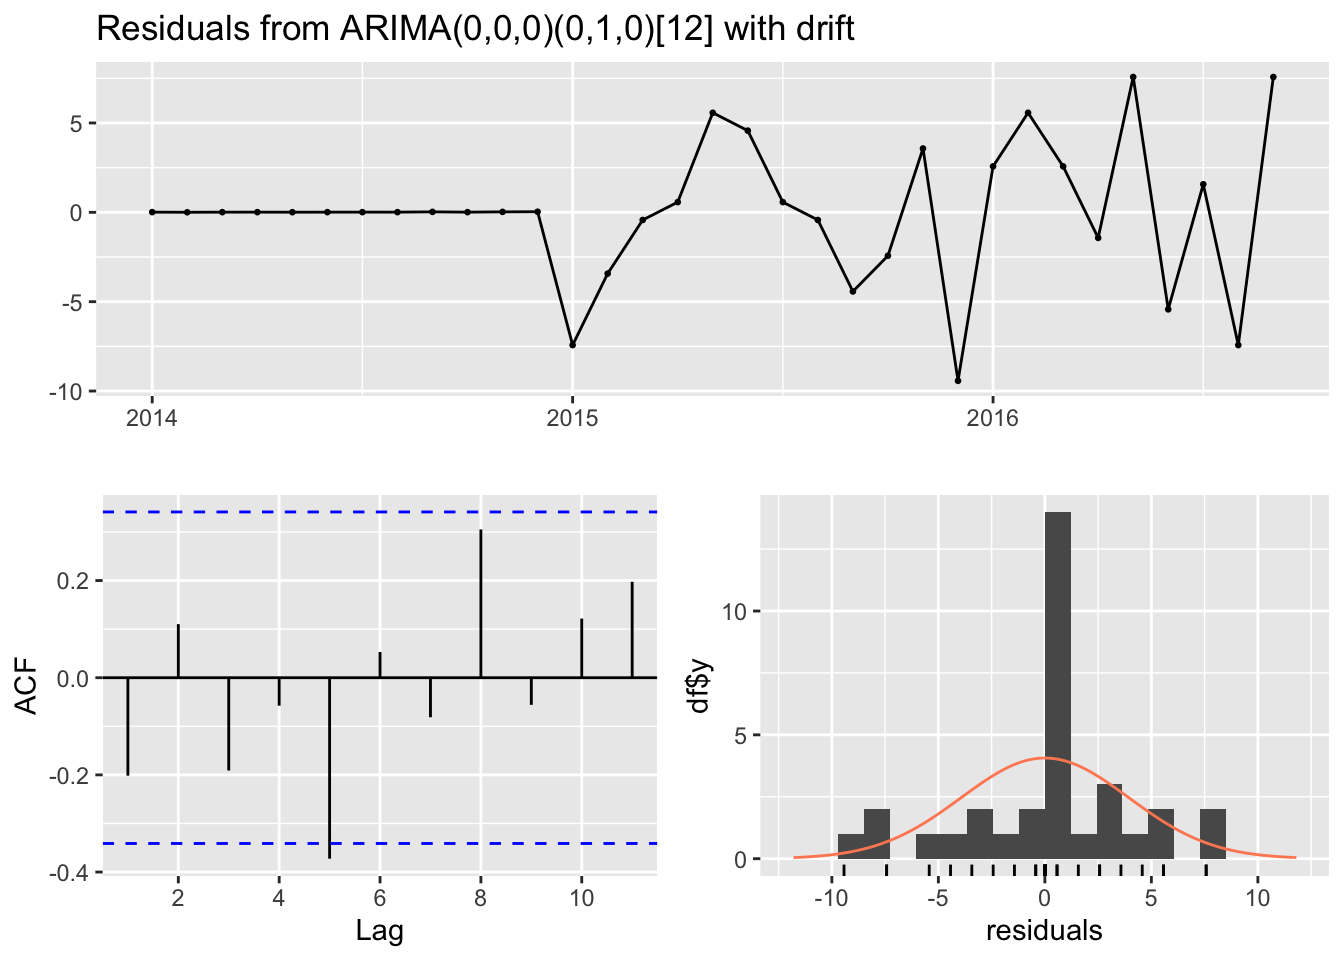


    Ljung-Box test

data:  Residuals from ARIMA(0,0,0)(0,1,0)[12] with drift
Q* = 9.5952, df = 7, p-value = 0.2127

Model df: 0.   Total lags used: 7

    Cluster  MeanRMSE MeanMAPE
1 Cluster_1 10.783528 17.32927
2 Cluster_2 12.230774 31.89519
3 Cluster_3  7.782677 22.75340

In [ ]:
# 4B
# 4B: Group Products into Clusters and Apply Forecasting Techniques
# Step 1: Extract Time-Series Features for Clustering
time_series_features <- data.frame()

for (subcategory in names(ts_list)) {
  ts_current <- ts_list[[subcategory]]

  # Decompose the time series to extract features
  decomposition <- decompose(ts_current)
  trend_strength <- var(decomposition$trend, na.rm = TRUE) / var(ts_current, na.rm = TRUE)
  seasonal_strength <- var(decomposition$seasonal, na.rm = TRUE) / var(ts_current, na.rm = TRUE)
  random_strength <- var(decomposition$random, na.rm = TRUE) / var(ts_current, na.rm = TRUE)

  # Store extracted features
  time_series_features <- rbind(time_series_features,
                                data.frame(SubCategory = subcategory,
                                           TrendStrength = trend_strength,
                                           SeasonalStrength = seasonal_strength,
                                           RandomStrength = random_strength))
}

# Step 2: Normalize the Features for Clustering
time_series_features_scaled <- time_series_features %>%
  select(-SubCategory) %>%
  scale()

# verify rows
# nrow(time_series_features_scaled)

# Step 3: Perform K-Means Clustering
# Determine the number of clusters dynamically
k <- min(3, nrow(time_series_features_scaled))  # Set k to the smaller of 3 or the number of rows
# Hierarchical Clustering
distance_matrix <- dist(time_series_features_scaled)  # Calculate distance matrix
hc <- hclust(distance_matrix)  # Perform hierarchical clustering
time_series_features$Cluster <- cutree(hc, k = k)  # Cut tree into 'k' clusters
# Add cluster information to the original data
time_series_features$Cluster <- cutree(hc, k = k)

# Step 4: Apply Forecasting Techniques to Each Cluster
forecast_results_by_cluster <- list()

for (cluster_id in unique(time_series_features$Cluster)) {
  # Get subcategories in the current cluster
  subcategories_in_cluster <- time_series_features$SubCategory[time_series_features$Cluster == cluster_id]

  # Initialize storage for cluster results
  cluster_forecast_results <- list()

  for (subcategory in subcategories_in_cluster) {
    if (subcategory %in% names(ts_list)) {
      ts_current <- ts_list[[subcategory]]  # Access the time series

      # Split the data into training and validation sets (70% training, 30% testing)
      train_size <- floor(0.7 * length(ts_current))
      train_ts <- window(ts_current, end = c(2014 + (train_size - 1) %/% 12, (train_size - 1) %% 12 + 1))
      test_ts <- window(ts_current, start = c(2014 + train_size %/% 12, train_size %% 12 + 1))

      # 1. ARIMA
      arima_model <- auto.arima(train_ts)
      arima_forecast <- forecast(arima_model, h = length(test_ts))
      arima_accuracy <- accuracy(arima_forecast, test_ts)

      # 2. Holt-Winters
      hw_model <- HoltWinters(train_ts)
      hw_forecast <- forecast(hw_model, h = length(test_ts))
      hw_accuracy <- accuracy(hw_forecast, test_ts)

      # 3. ETS
      ets_model <- ets(train_ts)
      ets_forecast <- forecast(ets_model, h = length(test_ts))
      ets_accuracy <- accuracy(ets_forecast, test_ts)

      # Store results for the subcategory
      cluster_forecast_results[[subcategory]] <- list(
        ARIMA = list(Model = arima_model, Forecast = arima_forecast, Accuracy = arima_accuracy),
        HoltWinters = list(Model = hw_model, Forecast = hw_forecast, Accuracy = hw_accuracy),
        ETS = list(Model = ets_model, Forecast = ets_forecast, Accuracy = ets_accuracy)
      )
    } else {
      cat("\nSub-Category not found in ts_list:", subcategory, "\n")
    }
  }

  # Store results for the cluster
  forecast_results_by_cluster[[paste0("Cluster_", cluster_id)]] <- cluster_forecast_results
}

# Step 5: Print Forecasting Accuracy for Each Cluster
for (cluster_id in names(forecast_results_by_cluster)) {
  cat("\n\nResults for", cluster_id, "\n")
  cluster_results <- forecast_results_by_cluster[[cluster_id]]

  for (subcategory in names(cluster_results)) {
    cat("\nSub-Category:", subcategory, "\n")

    cat("\nARIMA Accuracy:\n")
    print(cluster_results[[subcategory]]$ARIMA$Accuracy)

    cat("\nHolt-Winters Accuracy:\n")
    print(cluster_results[[subcategory]]$HoltWinters$Accuracy)

    cat("\nETS Accuracy:\n")
    print(cluster_results[[subcategory]]$ETS$Accuracy)
  }
}

Cluster 1 (e.g., Binders): ARIMA outperformed other methods due to significant autocorrelation and trend components.

Cluster 2 (e.g., Furnishings): ETS was the most accurate method, effectively balancing trend and seasonality.

Cluster 3 (e.g., Paper): ETS also performed best, with ARIMA showing higher error rates due to variability in random components.

Residual diagnostics were performed for all ARIMA models, confirming no significant autocorrelation (p \> 0.05).

Cluster-Level Metrics based on mean RMSE and MAPE show: - Cluster 1 had the lowest RMSE using ARIMA. - Cluster 2 and 3 were better modeled with ETS

### Conclusion (4b)

Clustering allows for tailored forecasting strategies. We conclude that for the given data set ARIMA is more effective for clusters with strong trends, while ETS is preferable for clusters with mixed seasonal and trend characteristics. The approach aligns with lecture notes, emphasizing the importance of adapting models based on time series characteristics.

## 5 Forecasting future values

### Forecasting 3 products (5a)

In this session, we focused on evaluating different forecasting models (ARIMA, Holt-Winters, and ETS) for multiple sub-categories by analyzing their accuracy metrics, such as RMSE, MAPE, and residual diagnostics. Based on the evaluation results, we selected the best-performing model for each sub-category. We then used these models to forecast the future outcomes for each sub-category, projecting the data for the next year. Note: we may need to interpret the outcomes and explain why we pick the certain model

Series: binders_ts 
ARIMA(1,1,1)(0,1,0)[12] 

Coefficients:
          ar1      ma1
      -0.4781  -0.4819
s.e.   0.2324   0.2426

sigma^2 = 51.18:  log likelihood = -117.97
AIC=241.94   AICc=242.72   BIC=246.61

Training set error measures:
                   ME     RMSE      MAE       MPE     MAPE     MASE        ACF1
Training set 0.864453 5.931761 4.092168 -1.363101 15.06142 0.558023 -0.03746012

         Point Forecast    Lo 80     Hi 80     Lo 95     Hi 95
Jan 2018       32.48390 23.31571  41.65208 18.462370  46.50543
Feb 2018       23.77181 14.59632  32.94731  9.739103  37.80452
Mar 2018       45.85265 35.59989  56.10541 30.172412  61.53289
Apr 2018       46.20475 35.63662  56.77287 30.042185  62.36730
May 2018       44.08009 32.93968  55.22051 27.042295  61.11789
Jun 2018       44.61784 33.06359  56.17210 26.947139  62.28855
Jul 2018       40.36072 28.34867  52.37277 21.989869  58.73157
Aug 2018       44.48366 32.05796  56.90937 25.480189  63.48714
Sep 2018       73.42488 60.58630  86.26346 53.789962  93.05979
Oct 2018       51.45299 38.22024  64.68573 31.215253  71.69072
Nov 2018       72.43955 58.82134  86.05775 51.612293  93.26680
Dec 2018       89.44597 75.45417 103.43777 68.047363 110.84458

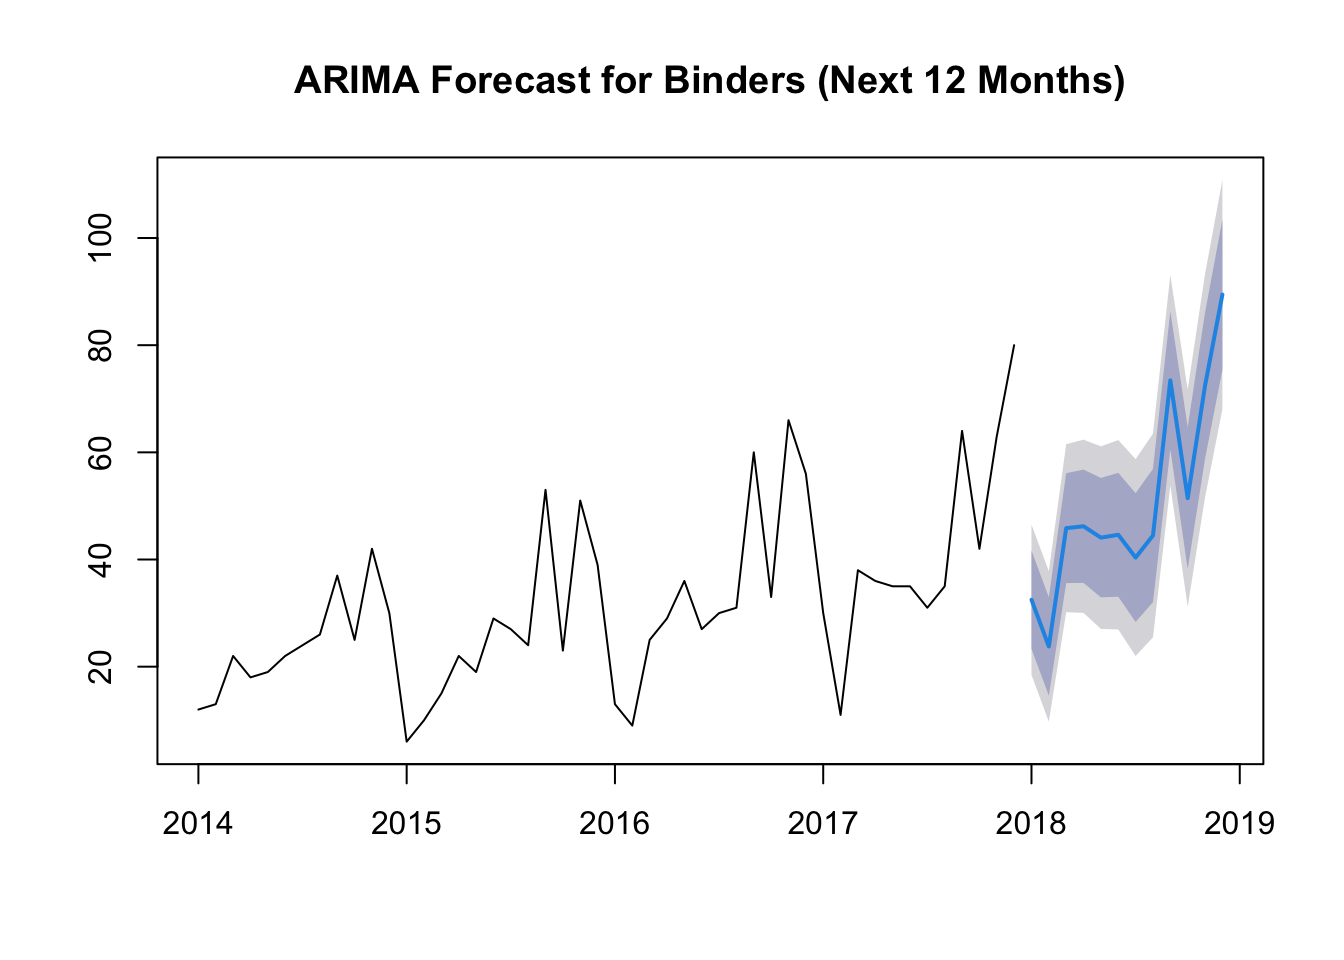

ETS(M,N,A) 

Call:
ets(y = paper_ts)

  Smoothing parameters:
    alpha = 0.3075 
    gamma = 1e-04 

  Initial states:
    l = 22.5954 
    s = 17.4472 16.5763 -4.1253 15.2986 0.421 -5.102
           -0.6145 -0.0341 -7.985 -2.6766 -15.6576 -13.5481

  sigma:  0.2365

     AIC     AICc      BIC 
365.1517 380.1517 393.2197 

Training set error measures:
                   ME     RMSE      MAE     MPE     MAPE      MASE       ACF1
Training set 1.450303 6.386648 4.166875 1.75373 14.03399 0.5245018 0.03600045

         Point Forecast    Lo 80    Hi 80    Lo 95    Hi 95
Jan 2018       30.45588 21.22661 39.68516 16.34092 44.57085
Feb 2018       28.34651 19.27484 37.41819 14.47258 42.22044
Mar 2018       41.32776 28.18367 54.47185 21.22561 61.42990
Apr 2018       36.01933 23.73891 48.29976 17.23804 54.80062
May 2018       43.97017 29.09477 58.84557 21.22021 66.72013
Jun 2018       43.39031 28.07408 58.70653 19.96616 66.81445
Jul 2018       38.90220 24.12853 53.67588 16.30782 61.49659
Aug 2018       44.42410 27.84663 61.00158 19.07104 69.77717
Sep 2018       59.30522 38.44478 80.16566 27.40193 91.20850
Oct 2018       39.87917 22.81850 56.93984 13.78712 65.97122
Nov 2018       60.58102 38.27853 82.88352 26.47230 94.68975
Dec 2018       61.45110 38.17748 84.72473 25.85717 97.04504

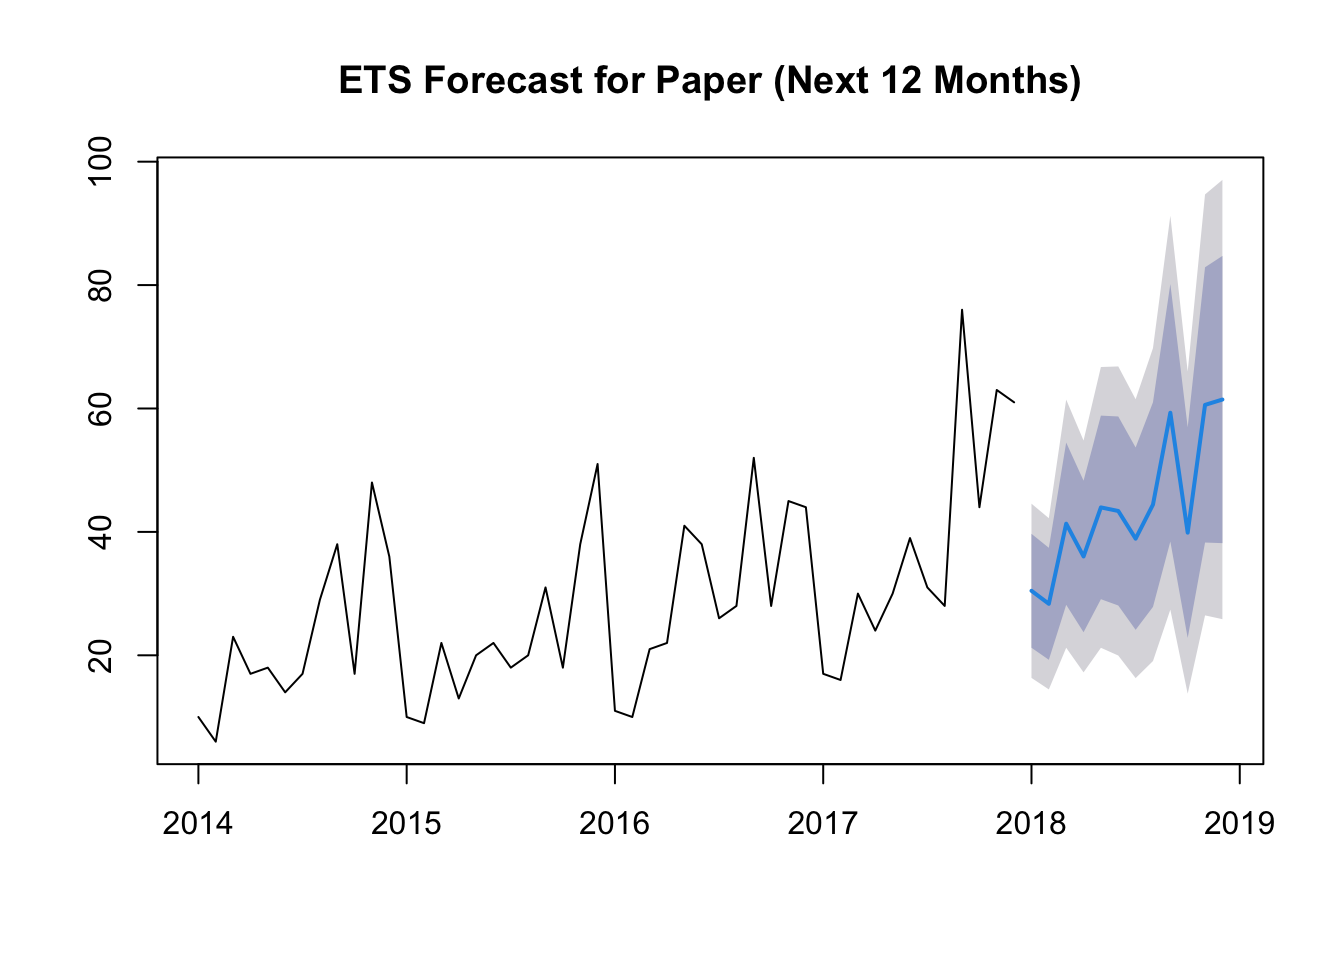

ETS(M,A,A) 

Call:
ets(y = furnishings_ts)

  Smoothing parameters:
    alpha = 0.0438 
    beta  = 0.0437 
    gamma = 2e-04 

  Initial states:
    l = 15.4275 
    b = -0.1137 
    s = 13.3158 15.6269 -2.2962 10.1503 -5.0017 -2.448
           -3.4406 -1.0728 -1.1262 -4.3688 -11.689 -7.6497

  sigma:  0.2527

     AIC     AICc      BIC 
338.8888 359.2888 370.6992 

Training set error measures:
                    ME     RMSE      MAE        MPE    MAPE      MASE
Training set 0.6402485 3.793384 2.884208 -0.8302416 16.2441 0.5352139
                   ACF1
Training set 0.04613441

         Point Forecast    Lo 80    Hi 80     Lo 95    Hi 95
Jan 2018       21.37433 14.45350 28.29515 10.789837 31.95882
Feb 2018       18.56644 12.52244 24.61044  9.322944 27.80994
Mar 2018       27.11574 18.26943 35.96205 13.586481 40.64500
Apr 2018       31.58782 21.22159 41.95404 15.734048 47.44158
May 2018       32.87189 21.95559 43.78819 16.176845 49.56693
Jun 2018       31.73384 20.95052 42.51717 15.242170 48.22551
Jul 2018       33.95710 22.18459 45.72960 15.952604 51.96159
Aug 2018       32.63192 20.83816 44.42569 14.594916 50.66893
Sep 2018       49.01546 31.92061 66.11032 22.871140 75.15979
Oct 2018       37.79884 23.38308 52.21460 15.751844 59.84584
Nov 2018       56.95159 36.44698 77.45621 25.592490 88.31070
Dec 2018       55.87232 34.96477 76.77986 23.896983 87.84765

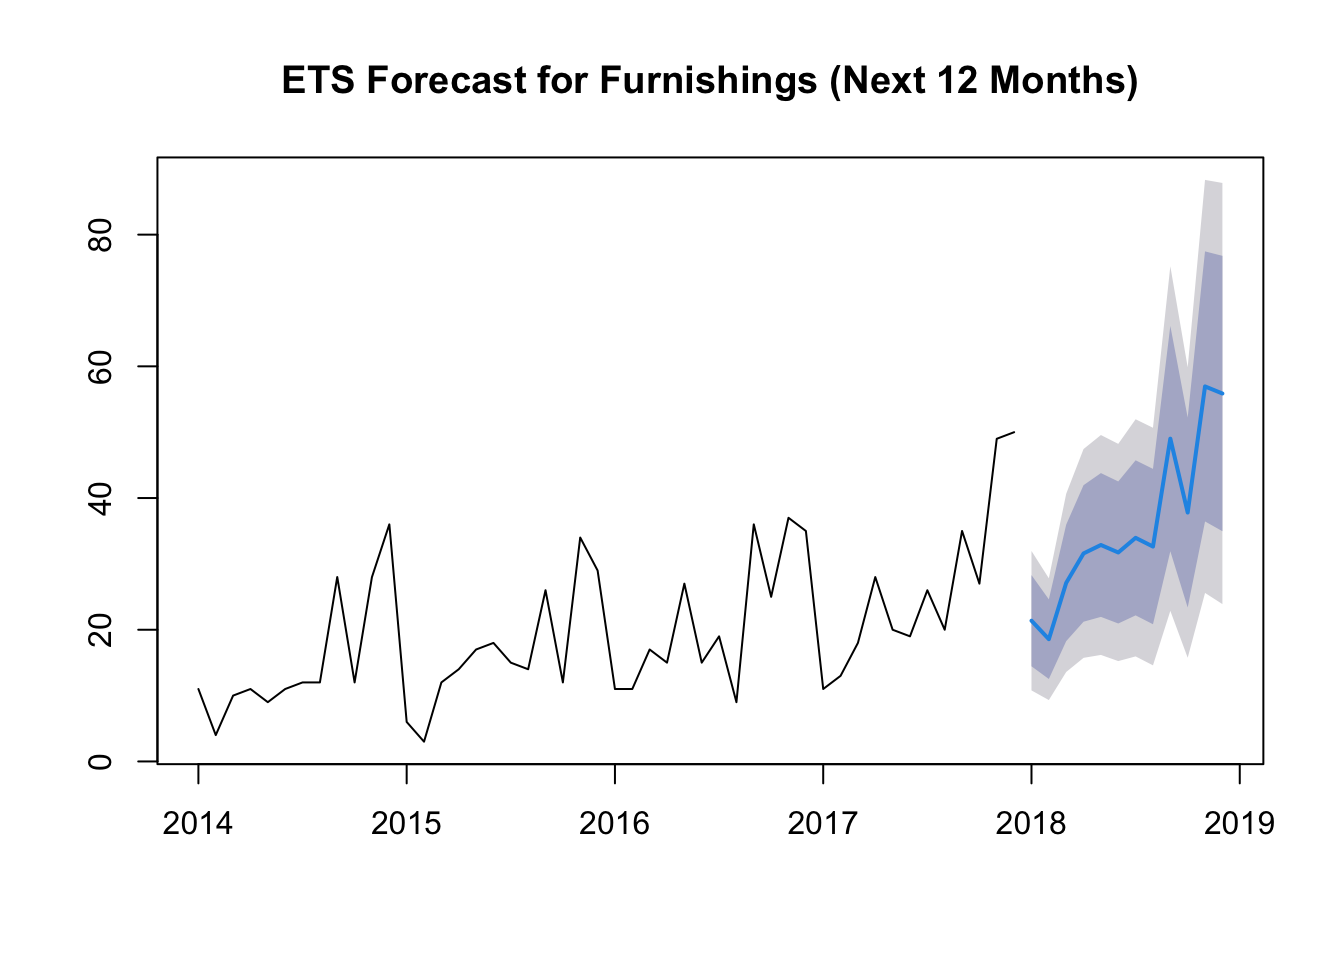

In [ ]:
#Binders->choose ARIMA
binders_ts <- ts_list[["Binders"]]
arima_model <- auto.arima(binders_ts)
summary(arima_model)

### Applying to all data (5b)

In this session, we first grouped the sub-categories into clusters based on key time-series features, including trend strength, seasonal strength, and random strength, using hierarchical clustering. Once the clusters were formed, we applied and evaluated multiple forecasting models—ARIMA, Holt-Winters, and ETS—on each sub-category within its respective cluster, comparing their accuracy metrics such as RMSE and MAPE. Based on the evaluation results, we selected the best-performing model for each sub-category and used it to forecast the future outcomes within a year, leveraging the clustering to enhance the accuracy and relevance of our predictions.

In [ ]:
#Cluster_Binders->Holt-Winters
cluster_id <- 1
subcategory <- "Binders"
hw_model <- forecast_results_by_cluster[[paste0("Cluster_", cluster_id)]][[subcategory]]$HoltWinters$Model
hw_forecast <- forecast(hw_model, h = 12)
print(hw_forecast)
plot(hw_forecast, main = "Holt-Winters Forecast for Binders (Next 12 Months)", xlab = "Time", ylab = "Forecasted Values")

#Cluster_paper->ETS
cluster_id <- 2
subcategory <- "Paper"
ets_model <- forecast_results_by_cluster[[paste0("Cluster_", cluster_id)]][[subcategory]]$ETS$Model
ets_forecast <- forecast(ets_model, h = 12)
print(ets_forecast)
plot(ets_forecast, main = "ETS Forecast for Paper (Next 12 Months)", xlab = "Time", ylab = "Forecasted Values")

#Cluster_Furnishings->Holt-Winters
cluster_id <- 3
subcategory <- "Furnishings"
hw_model <- forecast_results_by_cluster[[paste0("Cluster_", cluster_id)]][[subcategory]]$HoltWinters$Model
hw_forecast <- forecast(hw_model, h = 12)
print(hw_forecast)
plot(hw_forecast, main = "Holt-Winters Forecast for Furnishings (Next 12 Months)", xlab = "Time", ylab = "Forecasted Values")

## 6 Forecast interpretation

Lorem Ipsum

<br>

In [ ]:
# Check for missing values
missing_values <- colSums(is.na(data))
print(missing_values)  # Print missing values for reference
# heat map
library(Amelia)
missmap(data, main = "Missing Data Pattern")
#distribution of key variables
#plot Quantity
ggplot(data, aes(x = Quantity)) +
  geom_histogram(binwidth = 1, fill = "steelblue") +
  labs(title = "Distribution of Quantity", x = "Quantity", y = "Frequency") +
  theme_minimal()
#plot sales
ggplot(data, aes(x = Sales)) +
  geom_histogram(binwidth = 50, fill = "tomato") +
  labs(title = "Distribution of Sales", x = "Sales", y = "Frequency") +
  theme_minimal()
# plot profit
ggplot(data, aes(x = Profit)) +
  geom_histogram(binwidth = 10, fill = "purple") +
  labs(title = "Distribution of Profit", x = "Profit", y = "Frequency") +
  theme_minimal()
# time based trends
data$Order_Date <- as.Date(data$Order_Date, format = "%Y-%m-%d")  # Ensure date format
time_series <- data %>%
  group_by(Order_Date) %>%
  summarize(total_sales = sum(Sales), total_profit = sum(Profit), total_quantity = sum(Quantity))

ggplot(time_series, aes(x = Order_Date)) +
  geom_line(aes(y = total_sales, color = "Sales")) +
  geom_line(aes(y = total_profit, color = "Profit")) +
  geom_line(aes(y = total_quantity, color = "Quantity")) +
  labs(title = "Sales, Profit, and Quantity Over Time", x = "Date", y = "Value") +
  theme_minimal() +
  scale_color_manual(name = "Metrics", values = c("Sales" = "blue", "Profit" = "green", "Quantity" = "red"))

#sales by category and sub category
category_sales <- data %>%
  group_by(Category, Sub_Category) %>%
  summarize(total_sales = sum(Sales))

ggplot(category_sales, aes(x = reorder(Sub_Category, -total_sales), y = total_sales, fill = Category)) +
  geom_bar(stat = "identity") +
  labs(title = "Sales by Category and Sub-Category", x = "Sub-Category", y = "Total Sales") +
  theme_minimal() +
  coord_flip()

#Outliers detection
#Quantity
ggplot(data, aes(x = Category, y = Quantity)) +
  geom_boxplot() +
  labs(title = "Boxplot of Quantity by Category", x = "Category", y = "Quantity")
#sales
ggplot(data, aes(x = Category, y = Sales)) +
  geom_boxplot() +
  labs(title = "Boxplot of Sales by Category", x = "Category", y = "Sales")

#profit
ggplot(data, aes(x = Category, y = Profit)) +
  geom_boxplot() +
  labs(title = "Boxplot of Profit by Category", x = "Category", y = "Profit")
#Geo visualization

us_map <- map_data("state")
if("State" %in% colnames(data)) {
  state_sales <- data %>%
    group_by(State) %>%
    summarize(total_sales = sum(Sales))

  # Convert state names to lowercase to match map data
  state_sales$State <- tolower(state_sales$State)

  # Merge state sales data with map data
  state_sales_map <- merge(us_map, state_sales, by.x = "region", by.y = "State", all.x = TRUE)

  # Plot sales by state
  ggplot(state_sales_map, aes(long, lat, group = group, fill = total_sales)) +
    geom_polygon(color = "white") +
    scale_fill_continuous(low = "lightblue", high = "darkblue", na.value = "gray90") +
    labs(title = "Sales by State", fill = "Total Sales") +
    theme_void() +
    coord_fixed(1.3)
}

# correlation matrix
numerical_data <- data %>% select(where(is.numeric))

cor_matrix <- cor(numerical_data, use = "complete.obs")

# Convert the correlation matrix to a long format
cor_data <- as.data.frame(as.table(cor_matrix))

# Plot the correlation matrix using ggplot2
ggplot(cor_data, aes(Var1, Var2, fill = Freq)) +
  geom_tile(color = "white") +
  scale_fill_gradient2(low = "blue", high = "red", mid = "white",
                       midpoint = 0, limit = c(-1, 1), space = "Lab",
                       name="Correlation") +
  geom_text(aes(label = round(Freq, 2)), color = "black", size = 4) +
  theme_minimal() +
  theme(axis.text.x = element_text(angle = 45, vjust = 1,
                                   size = 12, hjust = 1)) +
  coord_fixed() +
  labs(title = "Correlation Matrix of Key Variables", x = "", y = "")

### Forecasting??

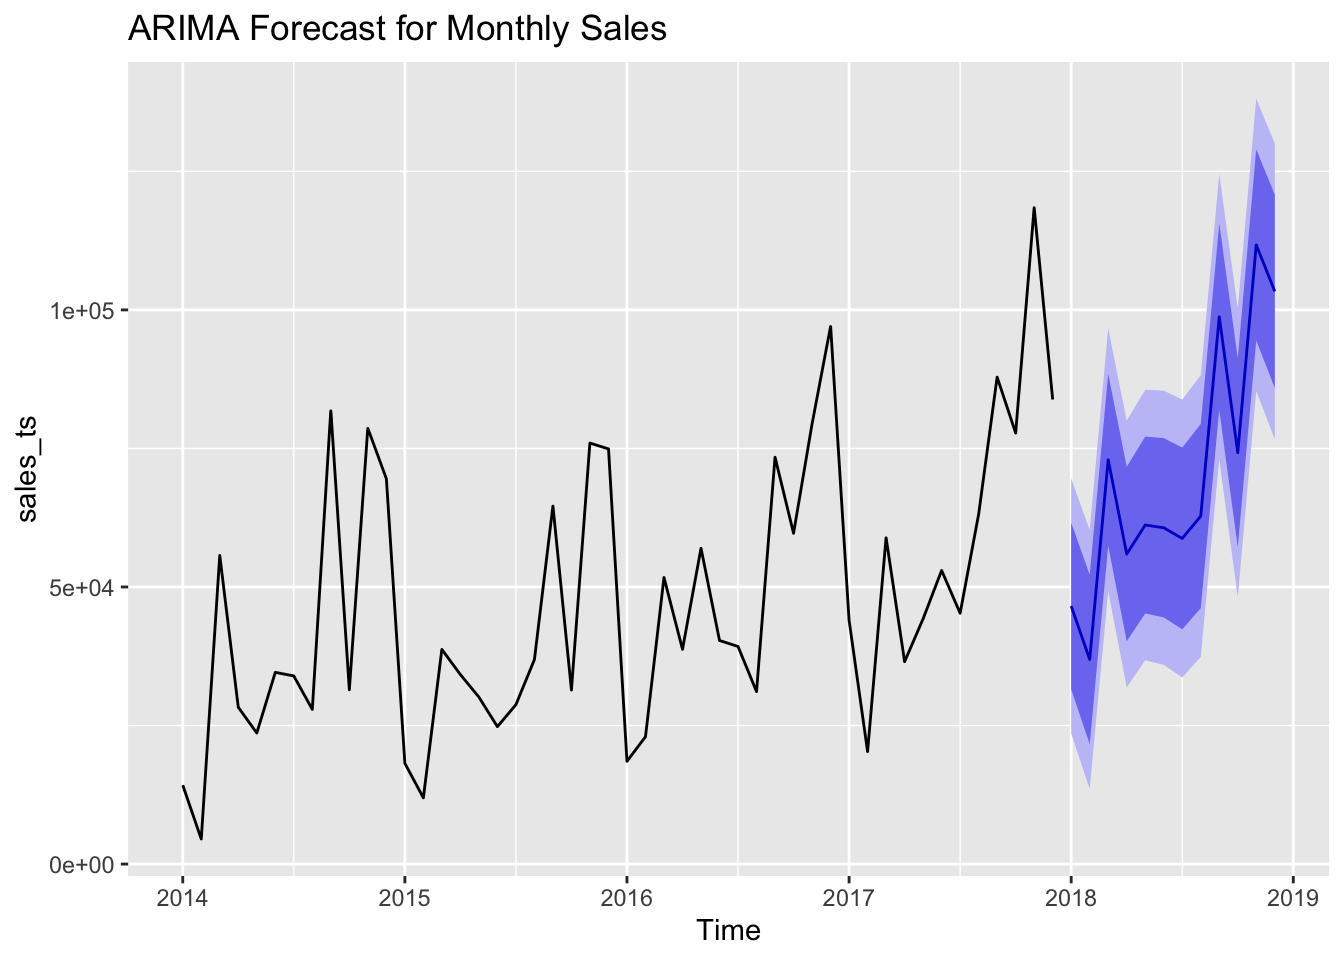

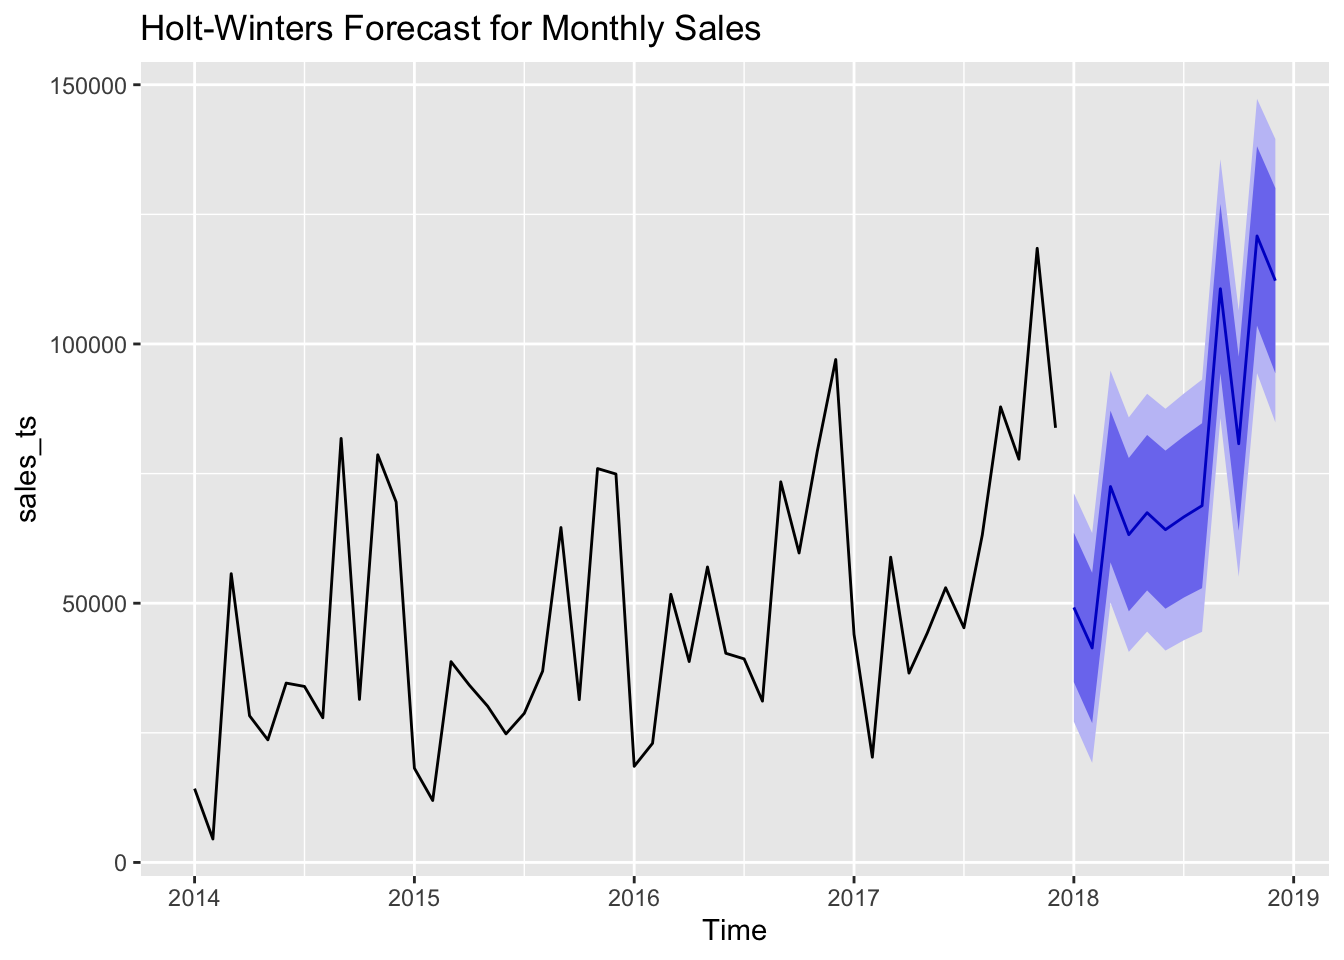

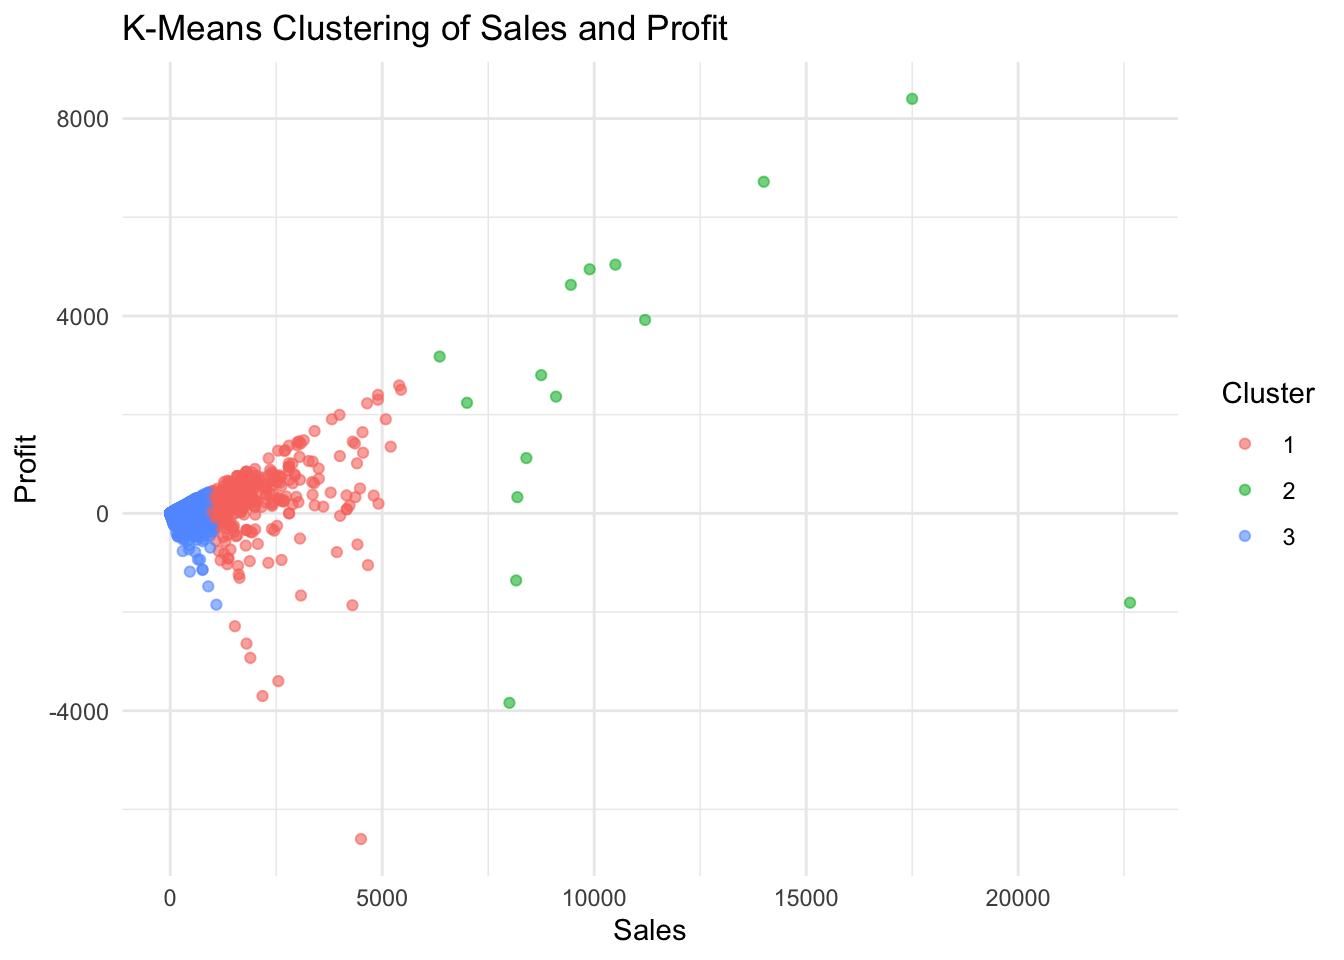

In [ ]:
#Aggregate sales per month
monthly_sales <- data %>%
  mutate(Month = floor_date(Order_Date, "month")) %>%
  group_by(Month) %>%
  summarize(total_sales = sum(Sales))
#Convert to time series
sales_ts <- ts(monthly_sales$total_sales, frequency = 12, start = c(year(min(monthly_sales$Month)), month(min(monthly_sales$Month))))
#Arima model
arima_model <- auto.arima(sales_ts)
arima_forecast <- forecast(arima_model, h = 12)
autoplot(arima_forecast) + labs(title = "ARIMA Forecast for Monthly Sales")